In [19]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from matplotlib import pyplot as plt
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
FINAL_DATA_DIR = '../staging/03_final/'
all_data_files = glob.glob(os.path.join(FINAL_DATA_DIR, '*.csv'))

if all_data_files:
    print(f"Found {len(all_data_files)} datasets to process:")
    for file_path in all_data_files:
        print(f"  - {os.path.basename(file_path)}")
else:
    print(f"ERROR: No data files found in '{FINAL_DATA_DIR}'")

Found 9 datasets to process:
  - Juicer.csv
  - Gas_stove.csv
  - Meat_grinder.csv
  - Rice_cooker.csv
  - fryer.csv
  - Dishwasher.csv
  - Washing_machine.csv
  - Stirrer.csv
  - Refrigerator.csv


In [21]:

def train_and_evaluate_models(X: pd.DataFrame, y: pd.Series):
    """
    Helper function to train models and return a results dataframe AND the best model object.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
        "Linear Regression": LinearRegression()
    }
    
    results = []
    best_model_so_far = None
    best_score_so_far = -np.inf

    for name, model_instance in models.items():
        model_instance.fit(X_train, y_train)
        predictions = model_instance.predict(X_test)
        r2 = mean_absolute_error(y_test, predictions)
        results.append({"Model": name, "R-squared (R2)": r2})
        
        if r2 > best_score_so_far:
            best_score_so_far = r2
            best_model_so_far = model_instance
            
    results_df = pd.DataFrame(results).sort_values(by="R-squared (R2)", ascending=False)
    return results_df, best_model_so_far, X_test, y_test


def run_full_analysis_for_category(file_path: str):
    """
    Runs a full analysis suite for a category, including EDA, model training,
    and post-training visualizations.
    """
    category_name = os.path.basename(file_path).replace('.csv', '')
    print(f"\n{'='*25} Starting Full Analysis for: {category_name.upper()} {'='*25}")
    
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        return {"Category": category_name, "Best Model (Price)": "Error", "R2 (Price)": 0, "Best Model (Rating_with_Price)": "Error", "R2 (Rating_with_Price)": 0, "Best Model (Rating_without_Price)": "Error", "R2 (Rating_without_Price)": 0}

    
    print(f"\n--- [EDA] Exploratory Analysis for {category_name} ---")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle(f'Distribution of Price and Rating for {category_name}', fontsize=16)
    sns.histplot(df['price'], kde=True, ax=axes[0], color='blue').set_title('Price Distribution')
    sns.histplot(df['rating'], kde=True, ax=axes[1], color='green').set_title('Rating Distribution')
    plt.show()

    plt.figure(figsize=(16, 12))
    numeric_df = df.select_dtypes(include=np.number)
    if len(numeric_df.columns) > 1:
        sns.heatmap(numeric_df.corr(), annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
        plt.title(f'Feature Correlation Matrix for {category_name}', fontsize=16)
        plt.show()
    
    summary = {"Category": category_name}
    experiments = {
        "Price": {"y_col": "price", "X_drop_cols": ['price', 'rating']},
        "Rating_with_Price": {"y_col": "rating", "X_drop_cols": ['rating']},
        "Rating_without_Price": {"y_col": "rating", "X_drop_cols": ['price', 'rating']}
    }
    
    for exp_name, config in experiments.items():
        print(f"\n--- Running Experiment: Predicting {exp_name} ---")
        
        X = df.drop(columns=config["X_drop_cols"], errors='ignore').select_dtypes(include=np.number)
        y = df[config["y_col"]]
        
        if X.empty or y.empty:
            print("  -> Could not run experiment due to missing data.")
            continue
            
        results_df, best_model, X_test, y_test = train_and_evaluate_models(X, y)
        
        best_model_name = results_df.iloc[0]['Model']
        best_model_score = results_df.iloc[0]['R-squared (R2)']
        
        summary[f"Best Model ({exp_name})"] = best_model_name
        summary[f"R2 ({exp_name})"] = best_model_score
        
        print(f"  -> Best Model Found: {best_model_name} (R2: {best_model_score:.4f})")
        
        
        final_predictions = best_model.predict(X_test)
        
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))
        fig.suptitle(f'Diagnostic Plots for Best Model ({best_model_name}) - Predicting {exp_name}', fontsize=16)
        
        if hasattr(best_model, 'feature_importances_'):
            importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
            sns.barplot(x=importances.values, y=importances.index, ax=axes[0], palette='plasma')
            axes[0].set_title('Top 10 Feature Importances')
        else:
            axes[0].text(0.5, 0.5, 'Feature importance not available.', ha='center')
            axes[0].set_title('Feature Importances')

        sns.scatterplot(x=y_test, y=final_predictions, ax=axes[1], alpha=0.7)
        axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
        axes[1].set_xlabel('Actual Values')
        axes[1].set_ylabel('Predicted Values')
        axes[1].set_title('Actual vs. Predicted')
        
        # نمودار ۳: باقیمانده‌ها
        residuals = y_test - final_predictions
        sns.scatterplot(x=final_predictions, y=residuals, ax=axes[2], alpha=0.7)
        axes[2].hlines(y=0, xmin=final_predictions.min(), xmax=final_predictions.max(), colors='r', linestyles='--')
        axes[2].set_xlabel('Predicted Values')
        axes[2].set_ylabel('Residuals')
        axes[2].set_title('Residuals Plot')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
    return summary

print("Function 'run_full_analysis_for_category' defined successfully.")

Function 'run_full_analysis_for_category' defined successfully.



========================= Starting Full Analysis for: JUICER =========================

--- [EDA] Exploratory Analysis for Juicer ---


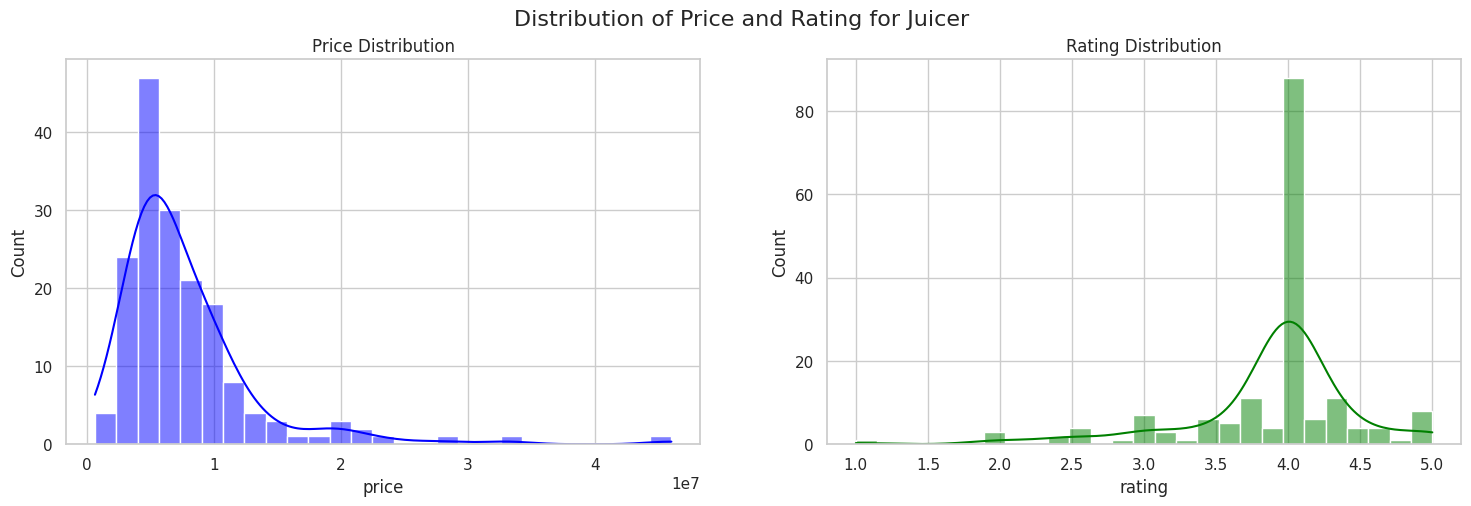

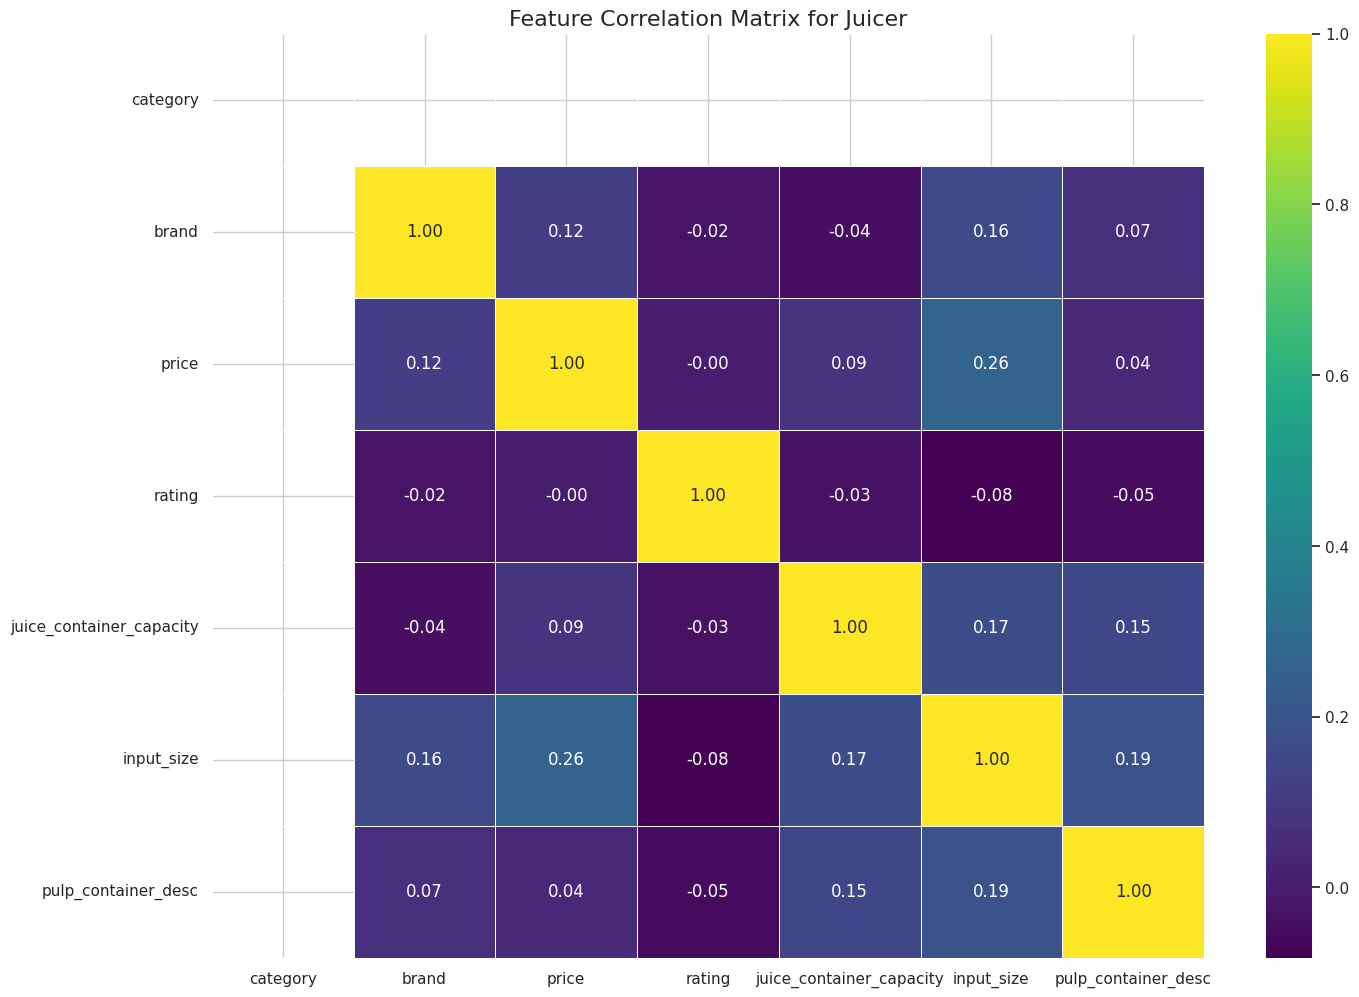


--- Running Experiment: Predicting Price ---
  -> Best Model Found: XGBoost (R2: 3728979.2500)


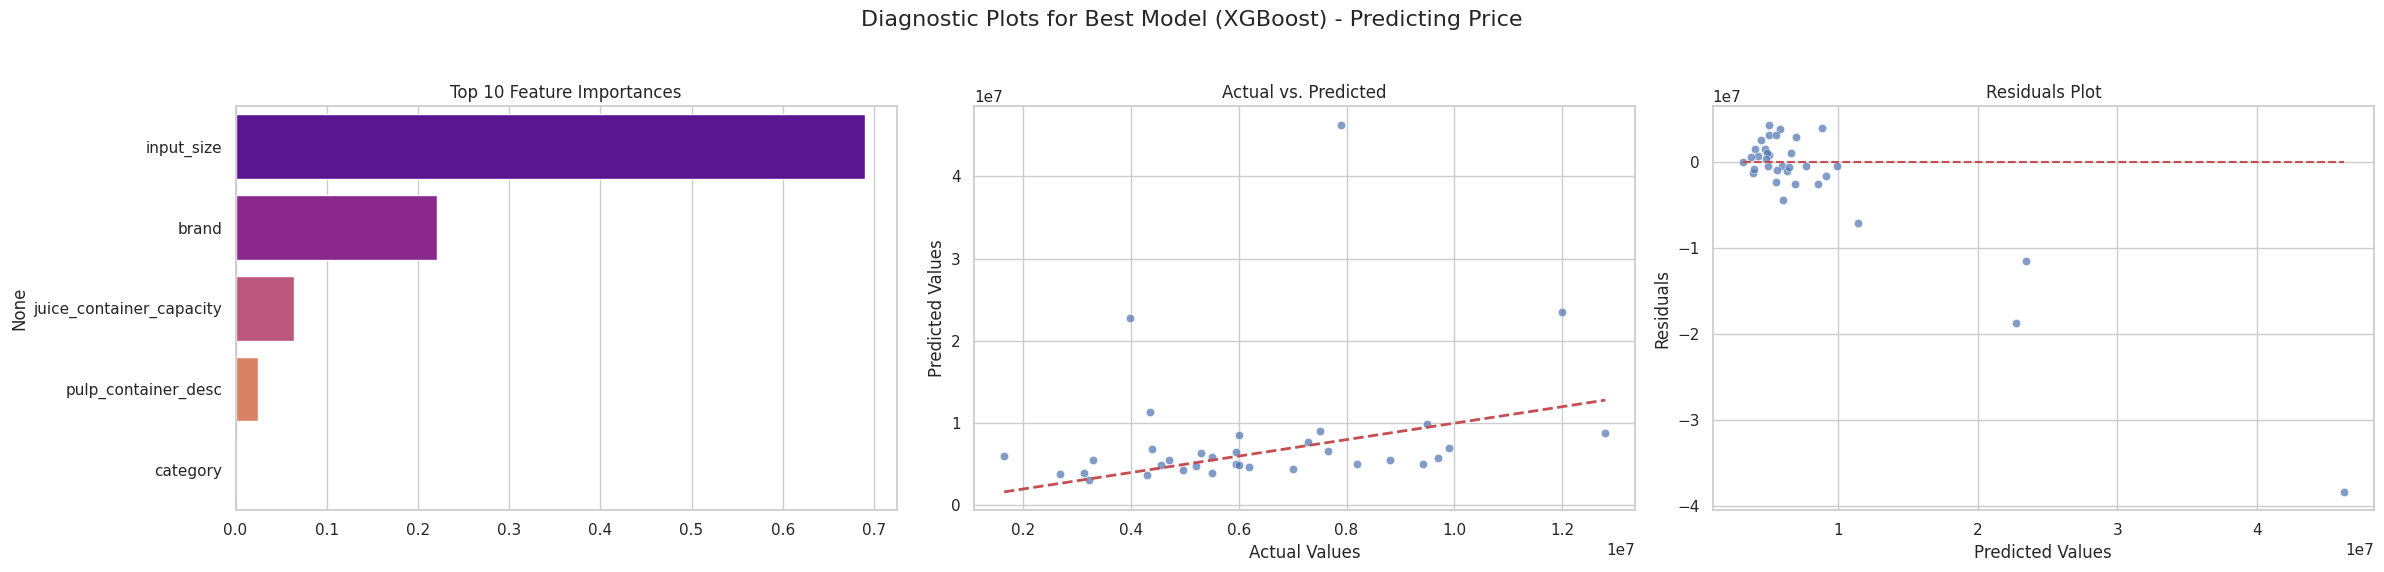


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: XGBoost (R2: 0.4816)


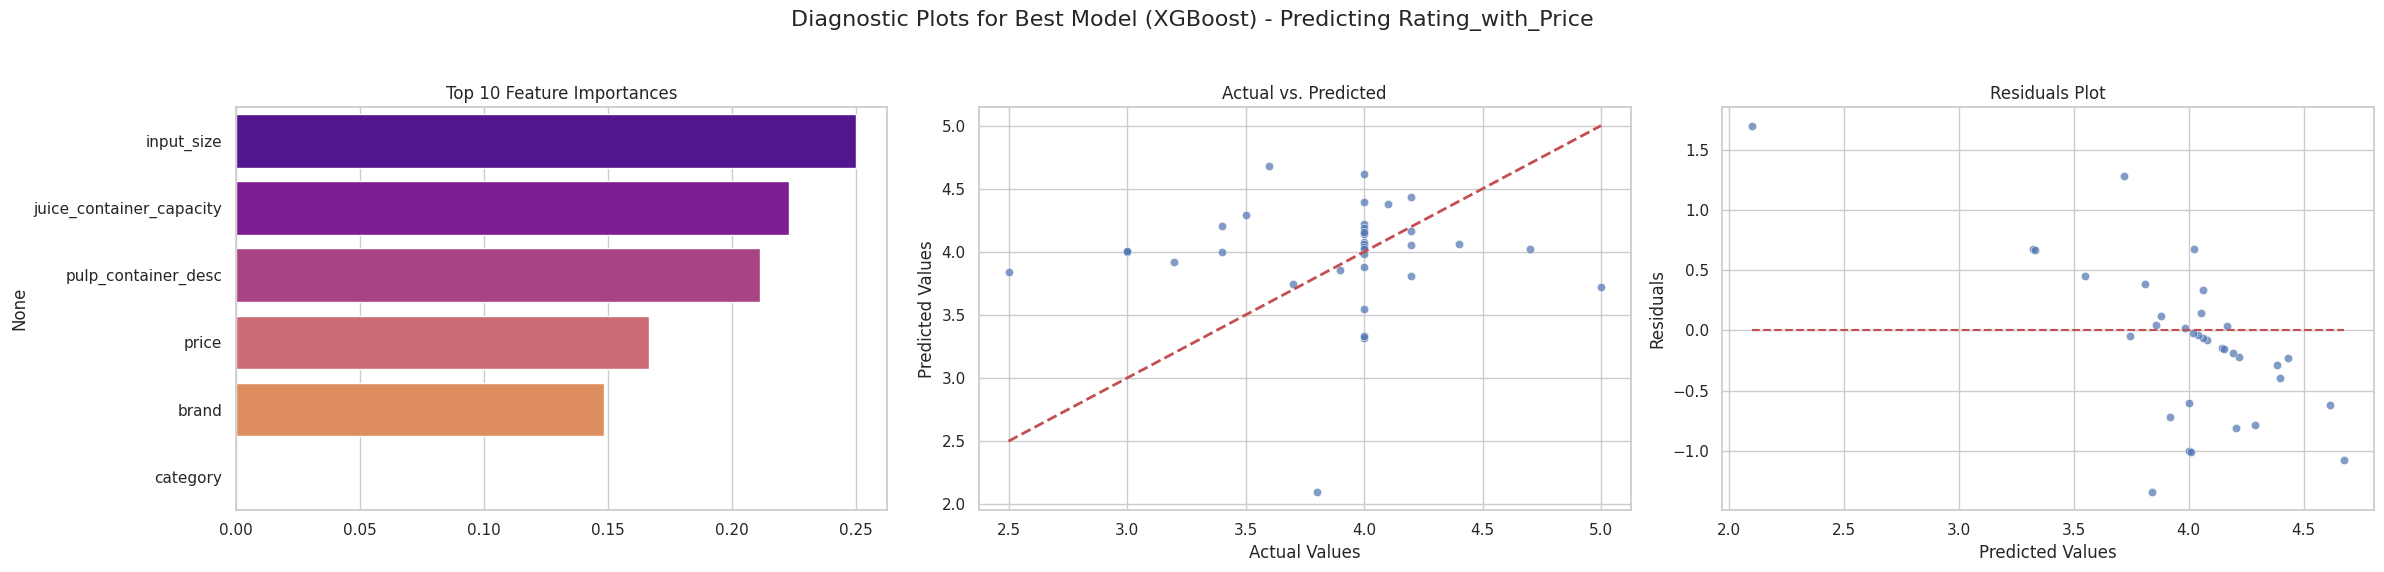


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.4020)


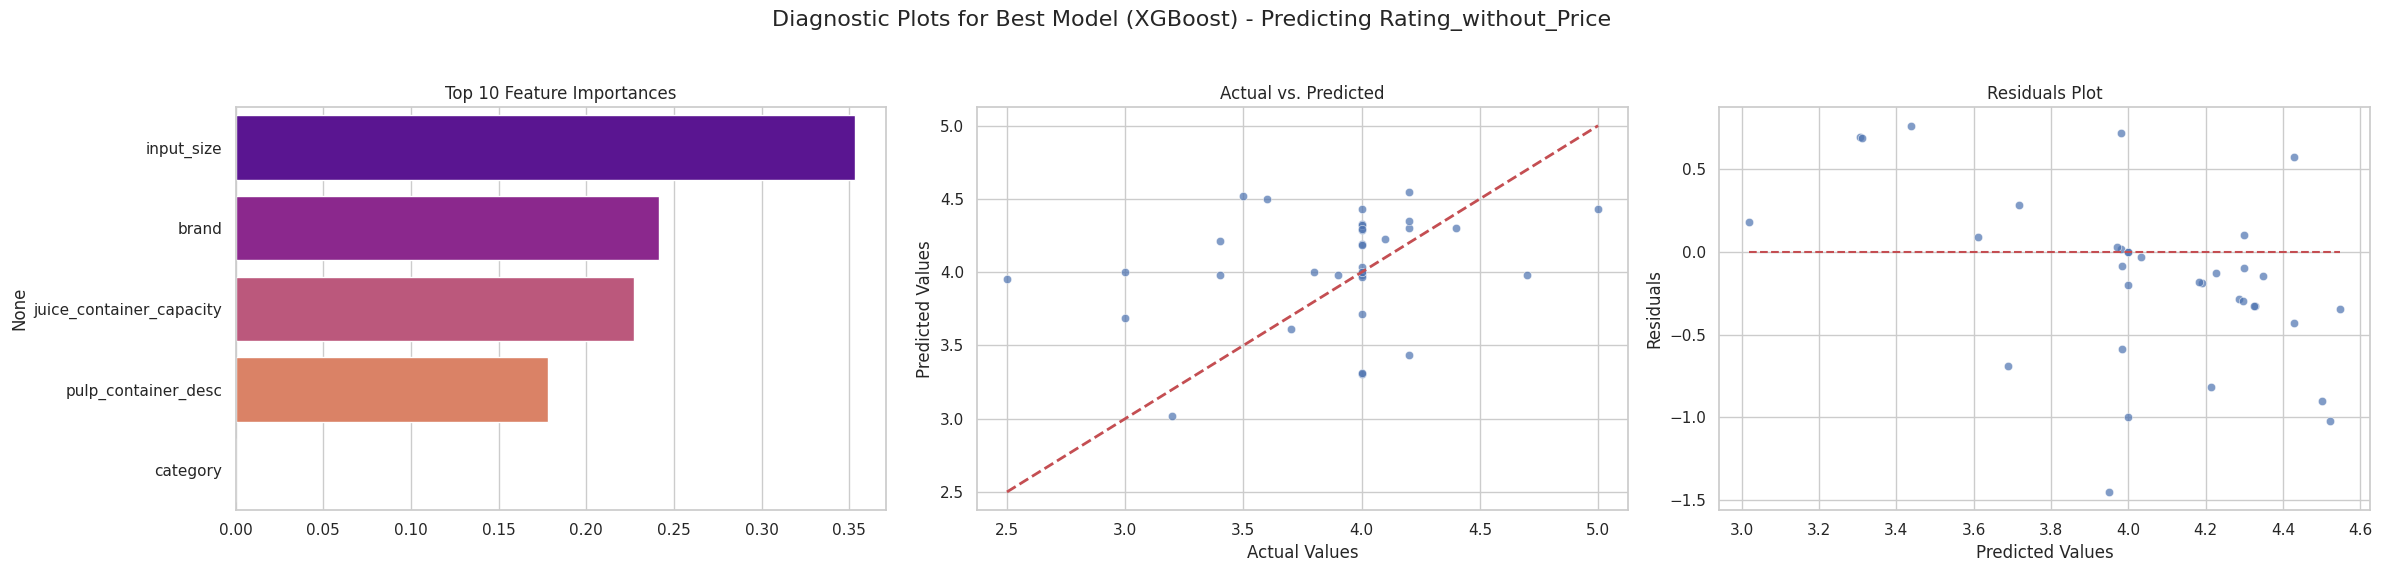


========================= Starting Full Analysis for: GAS_STOVE =========================

--- [EDA] Exploratory Analysis for Gas_stove ---


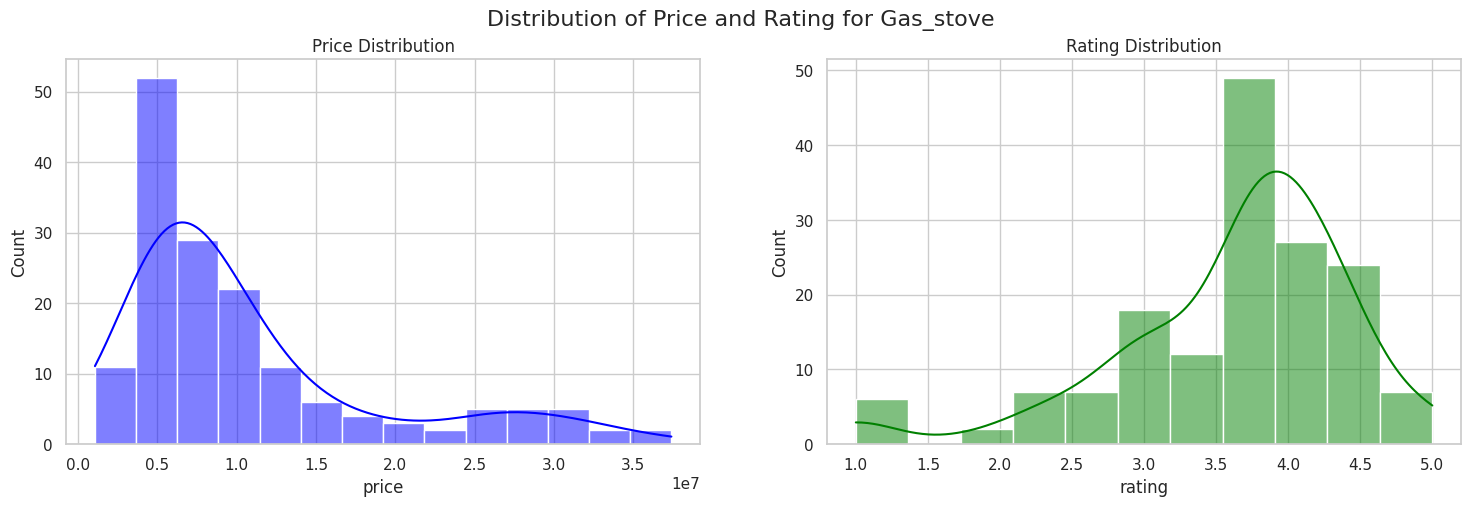

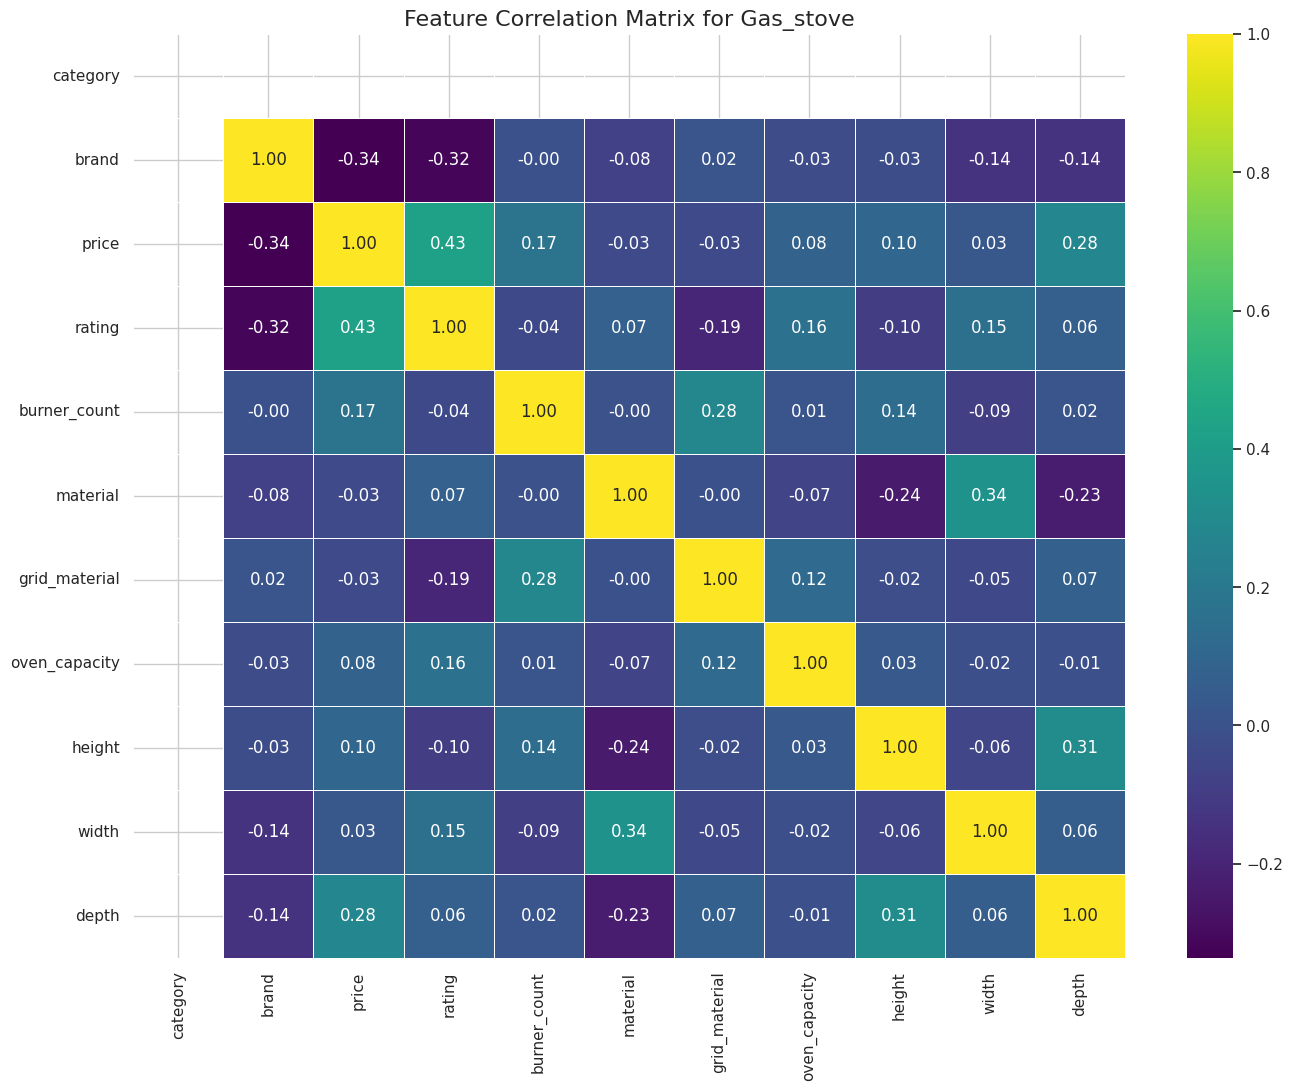


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 4736551.4114)


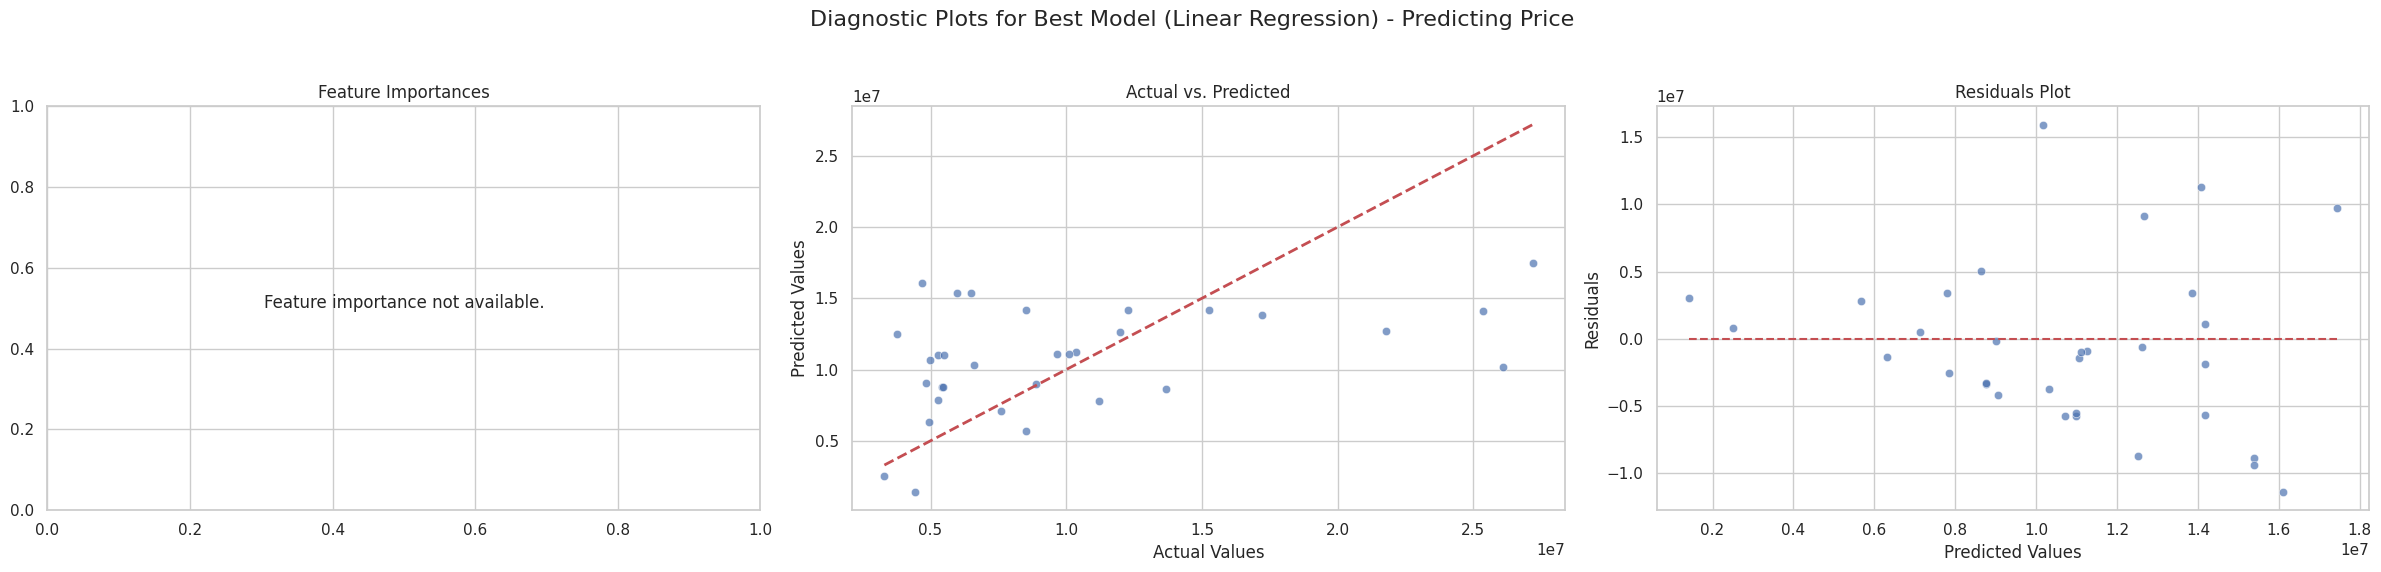


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: Linear Regression (R2: 0.6930)


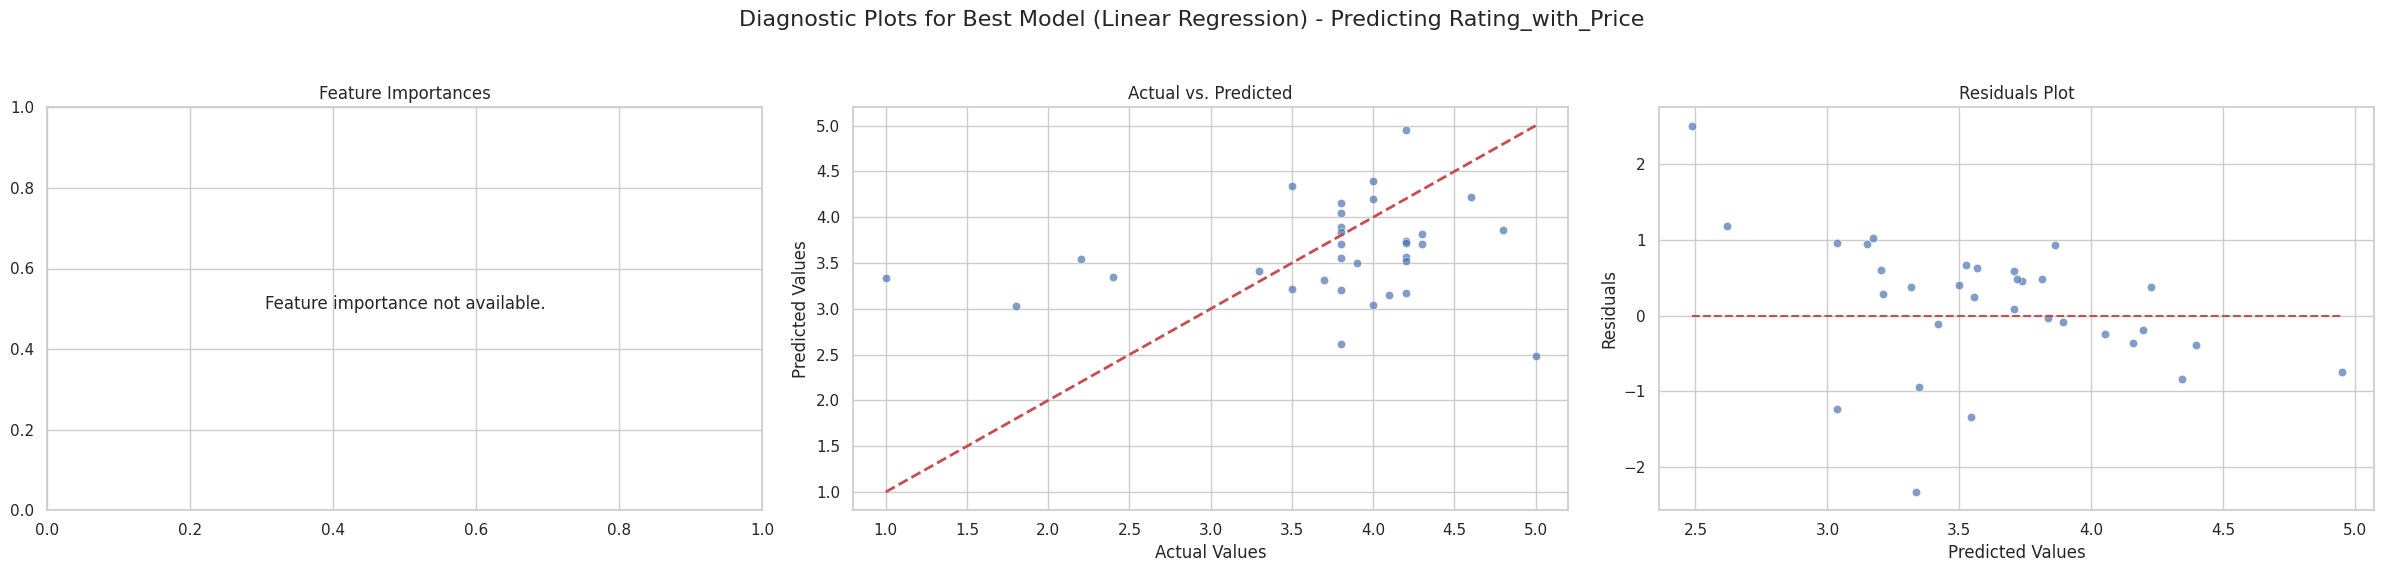


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: Linear Regression (R2: 0.6830)


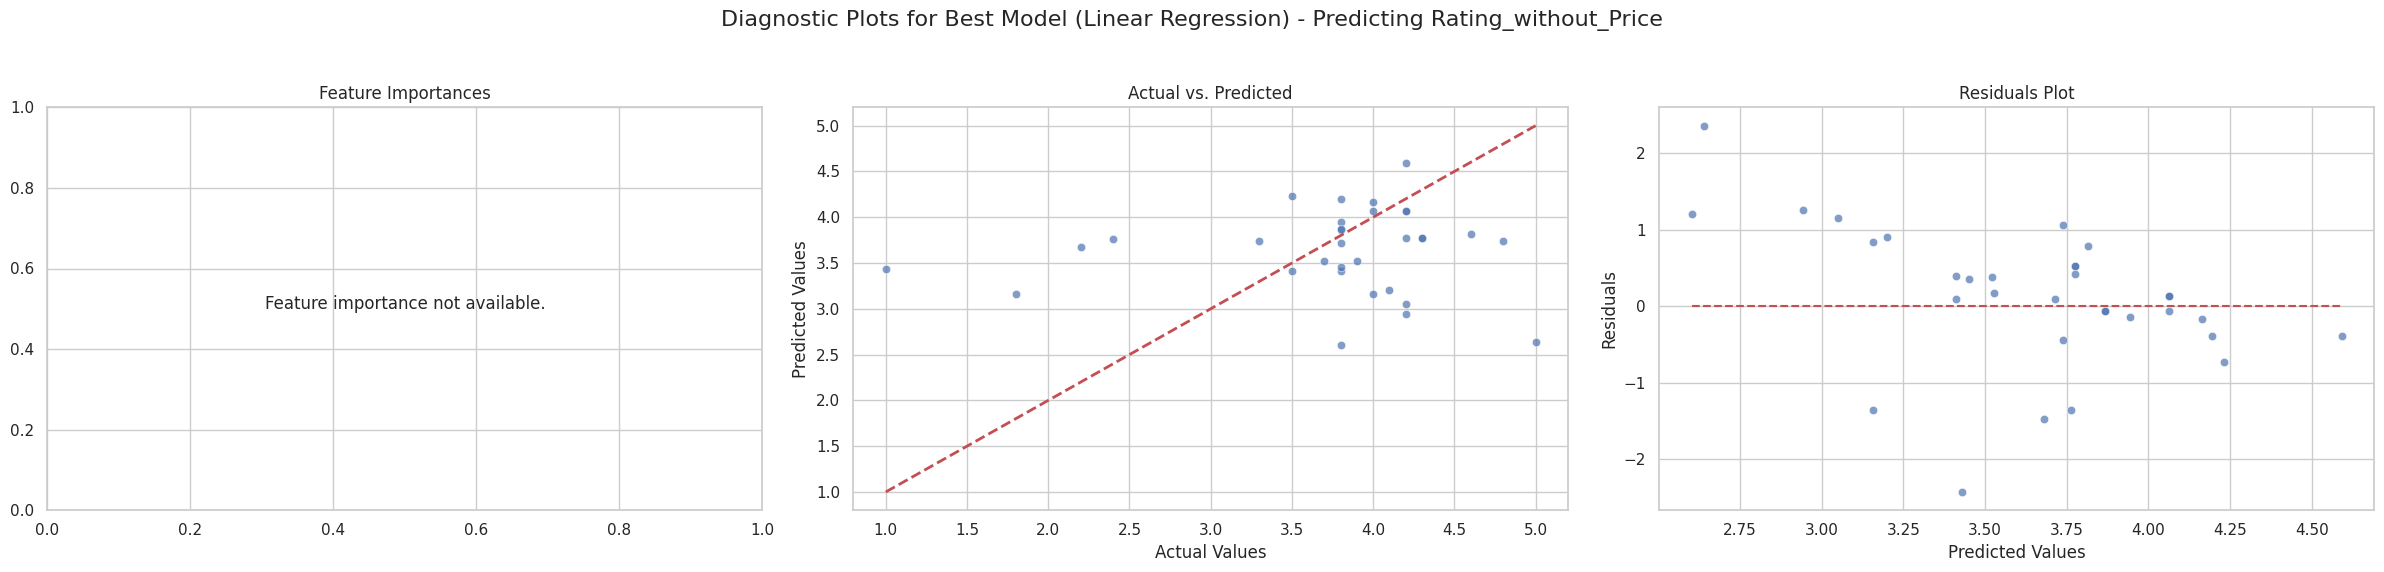


========================= Starting Full Analysis for: MEAT_GRINDER =========================

--- [EDA] Exploratory Analysis for Meat_grinder ---


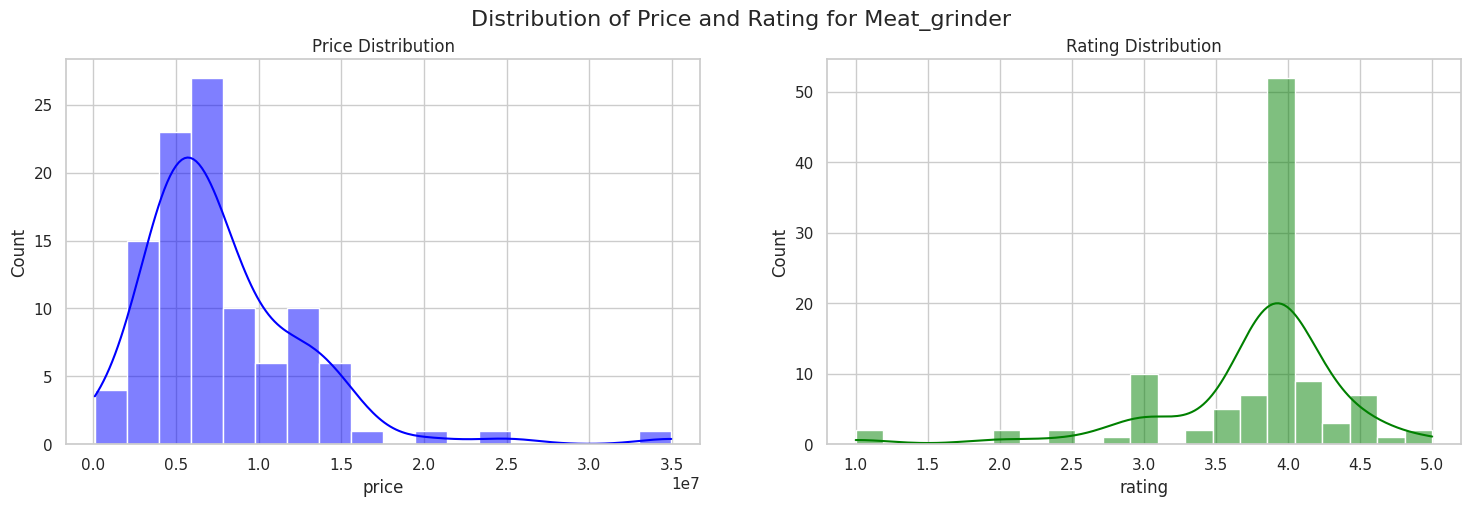

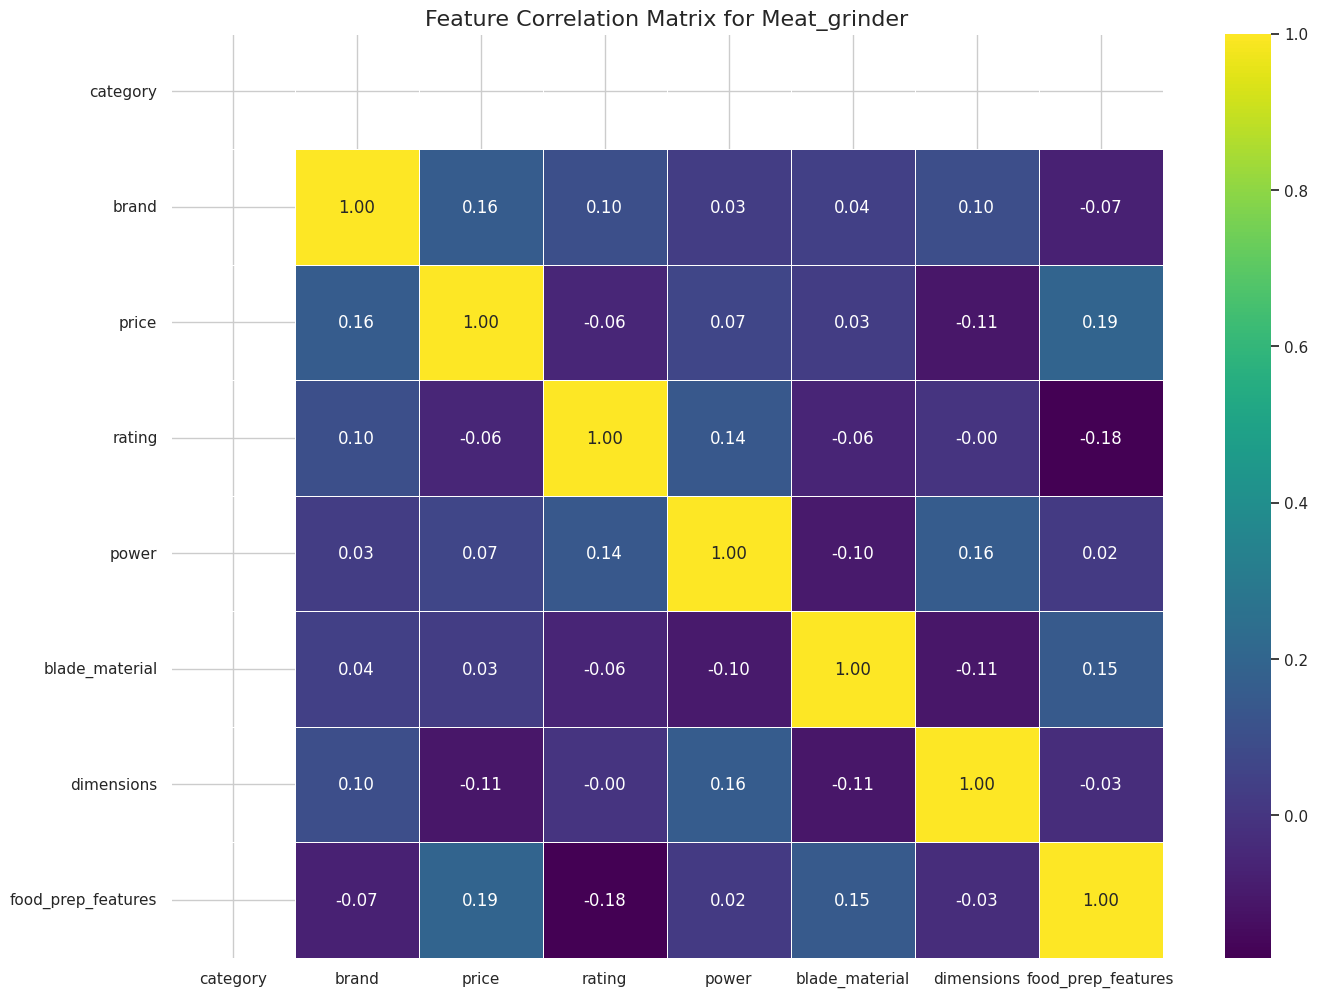


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Random Forest (R2: 3297480.2079)


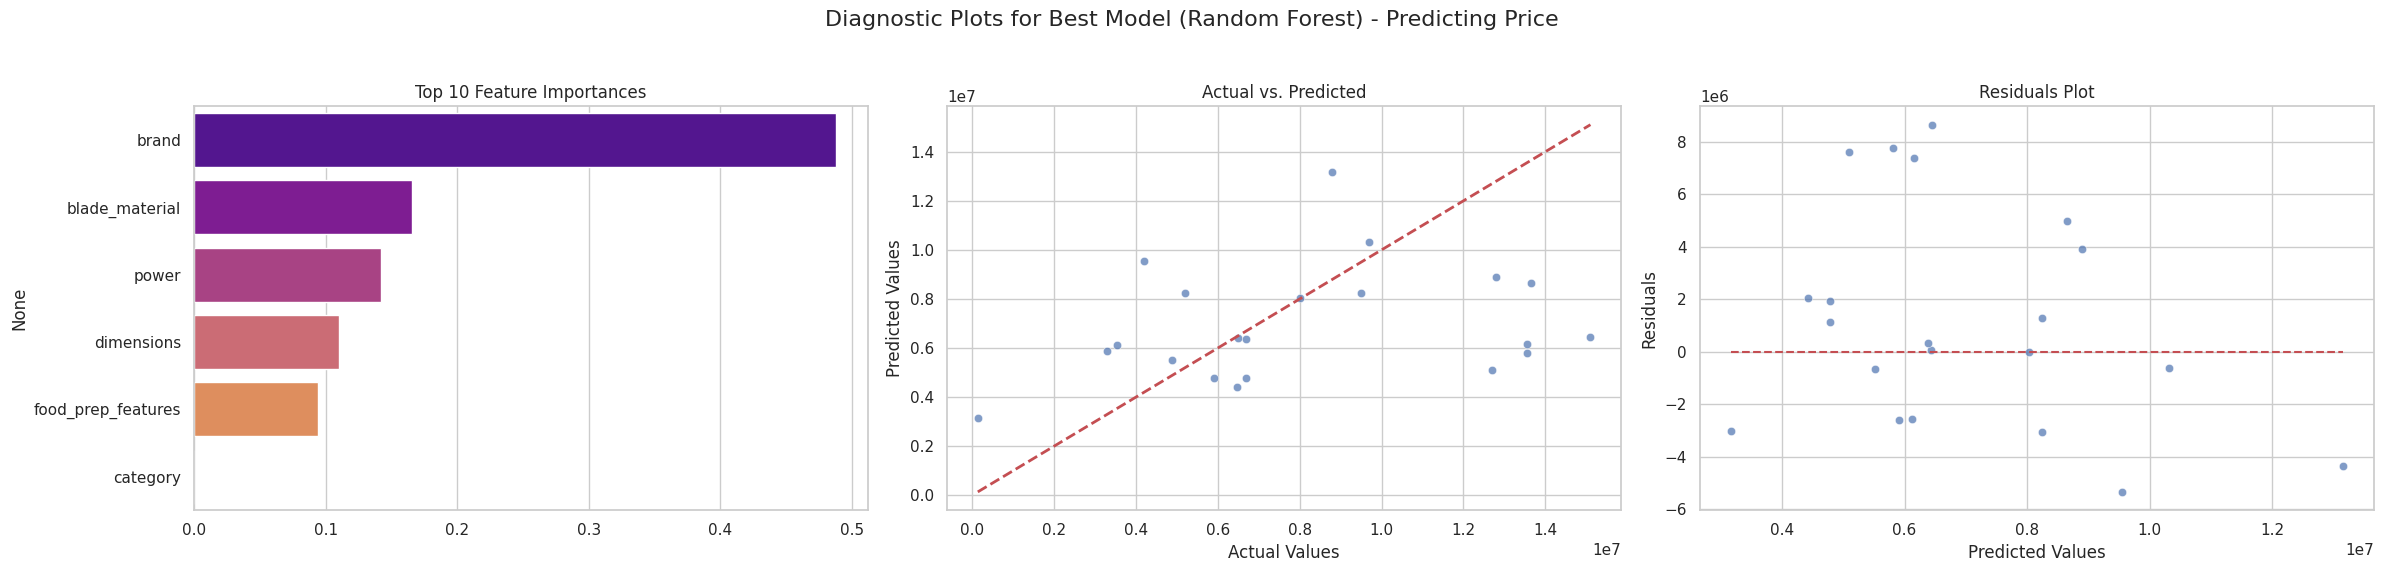


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: XGBoost (R2: 0.3841)


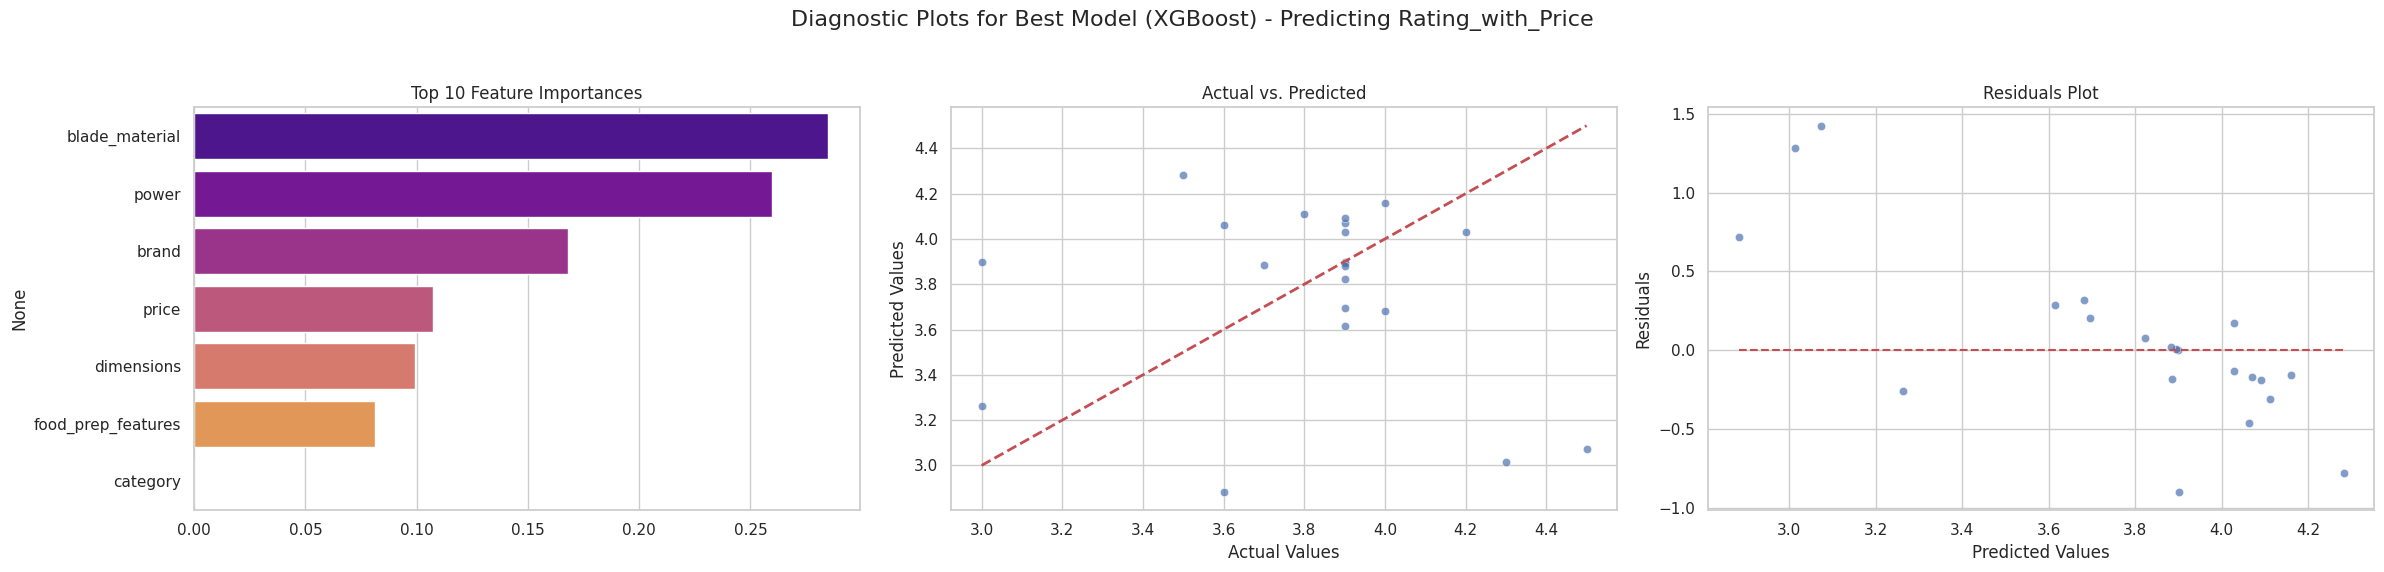


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.4067)


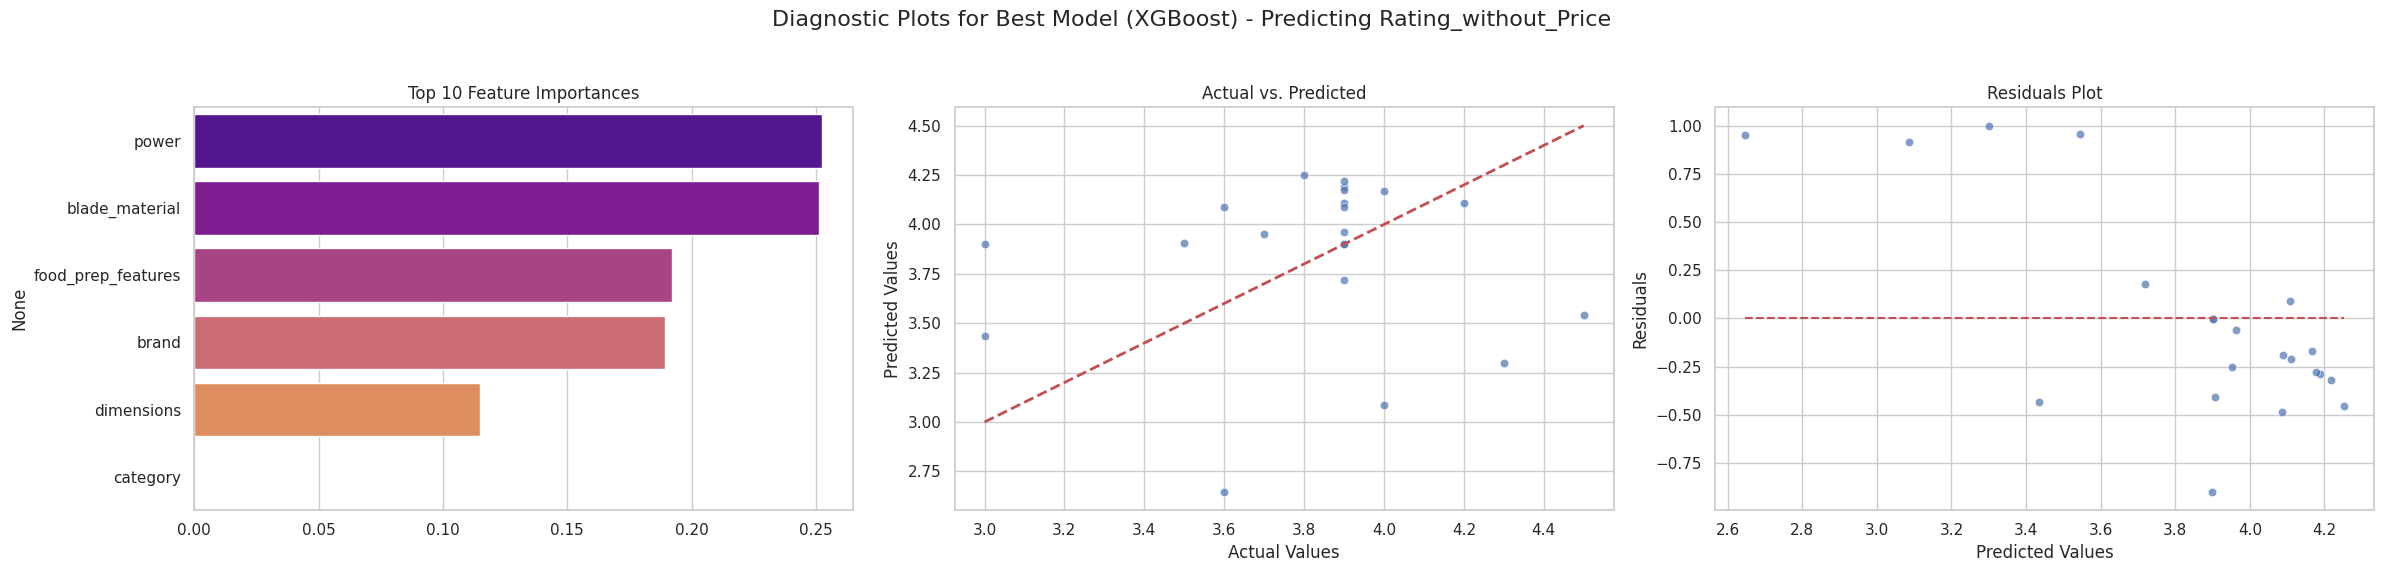


========================= Starting Full Analysis for: RICE_COOKER =========================

--- [EDA] Exploratory Analysis for Rice_cooker ---


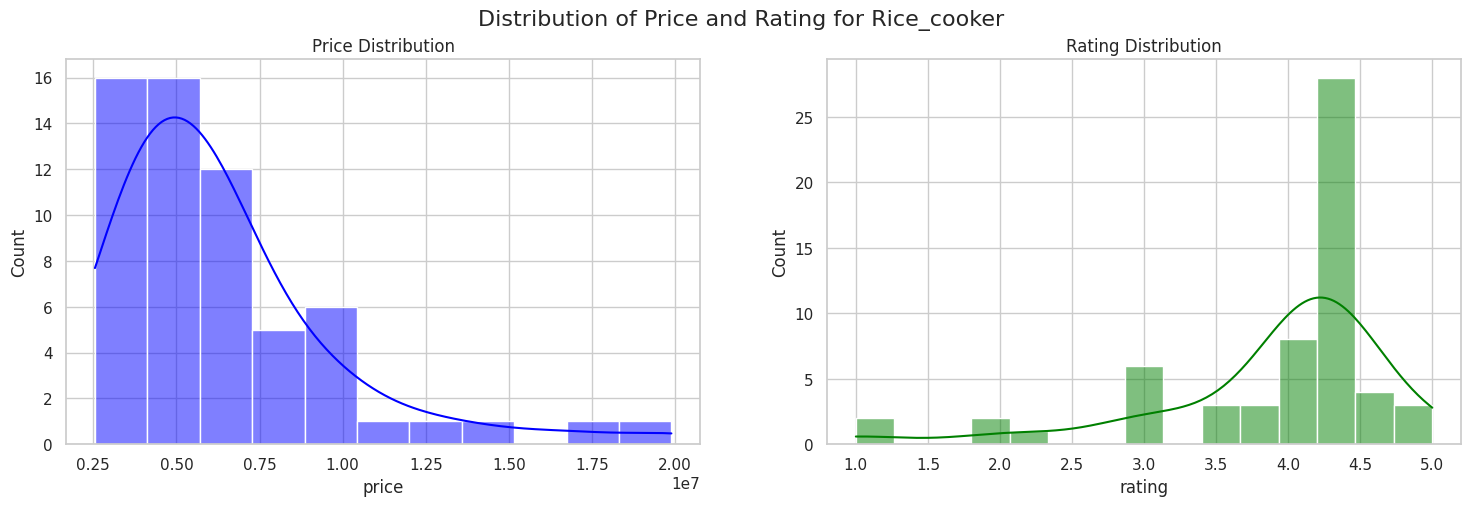

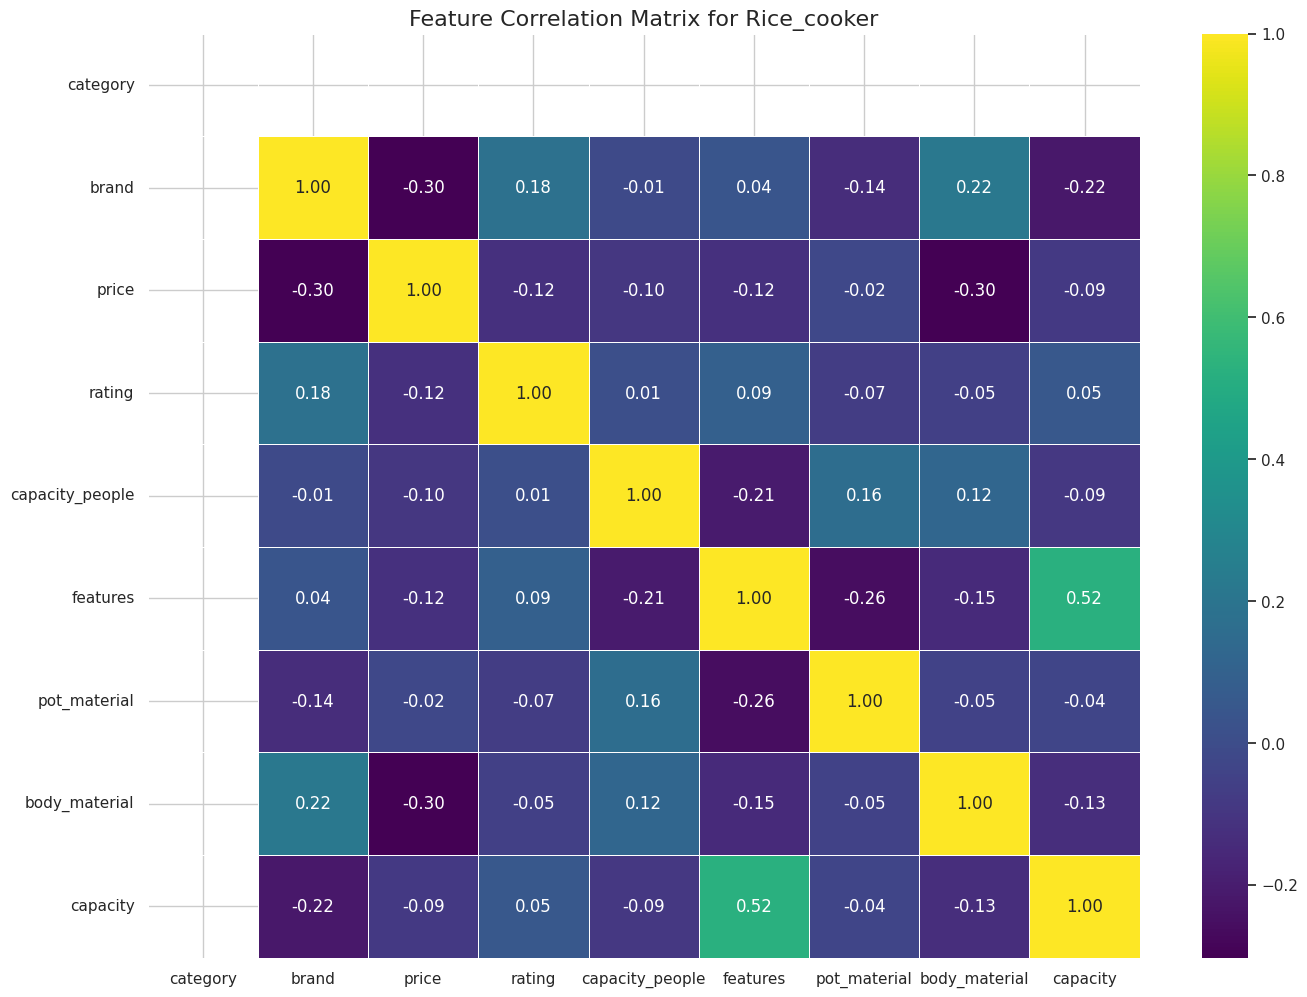


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 51341507.7155)


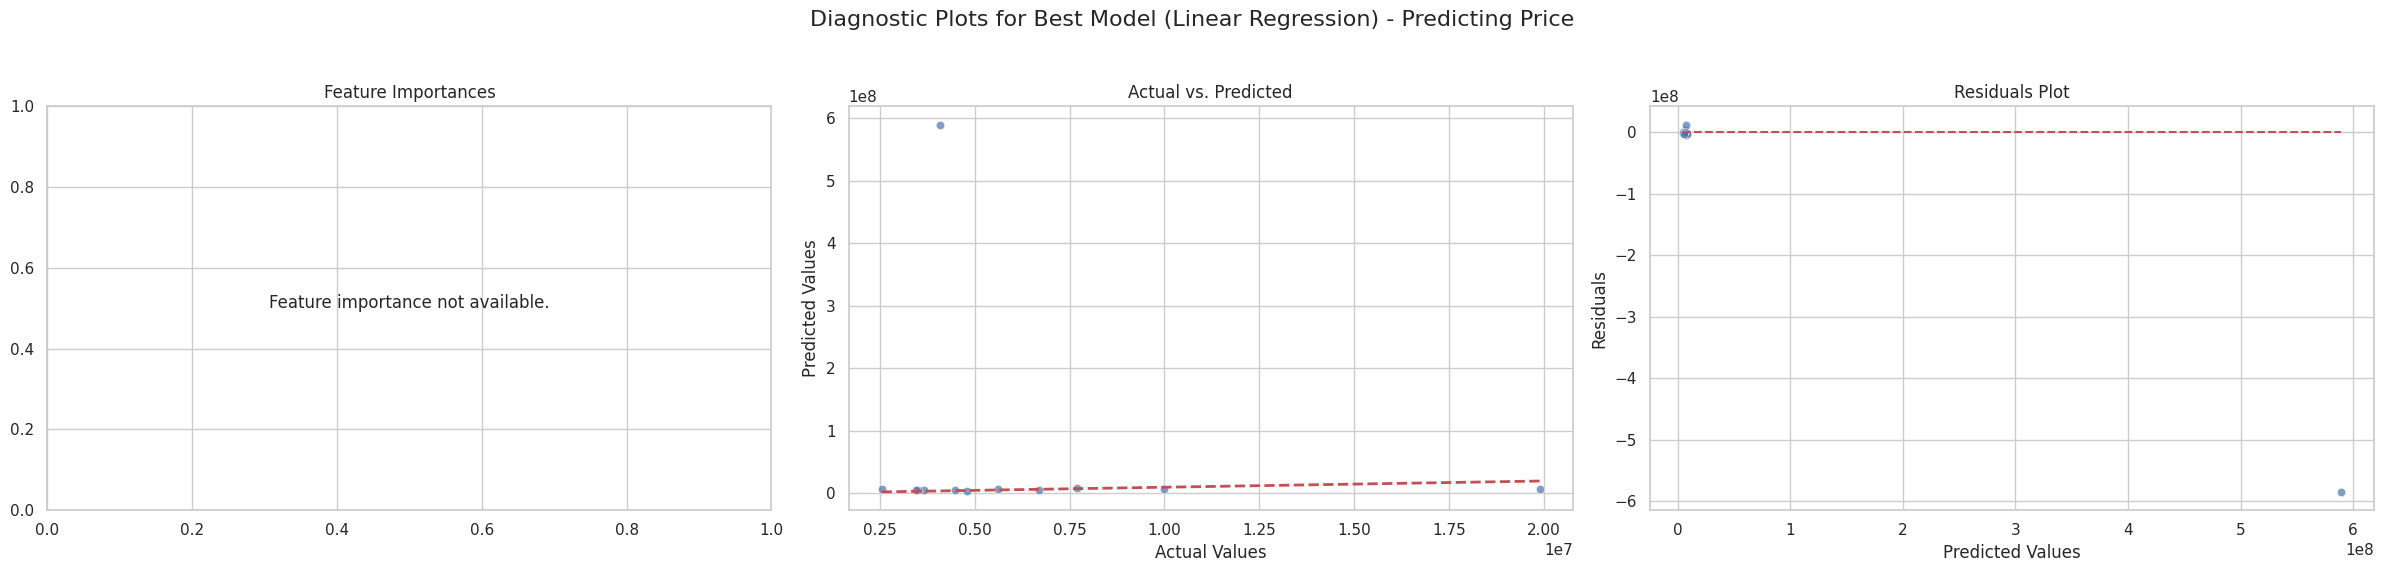


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: Linear Regression (R2: 2.1369)


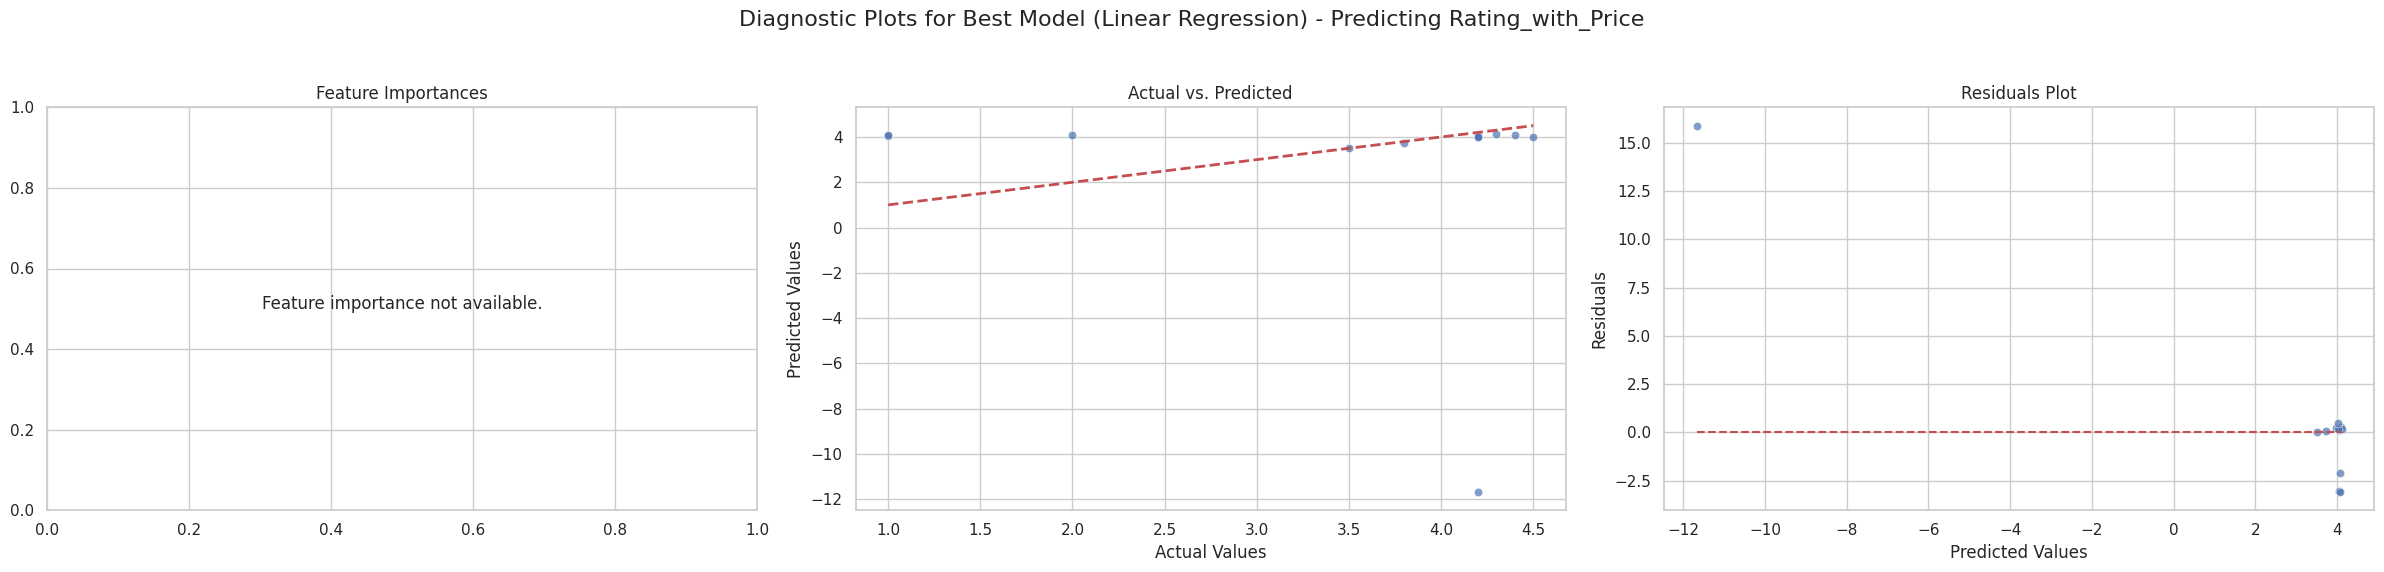


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: Linear Regression (R2: 3.7062)


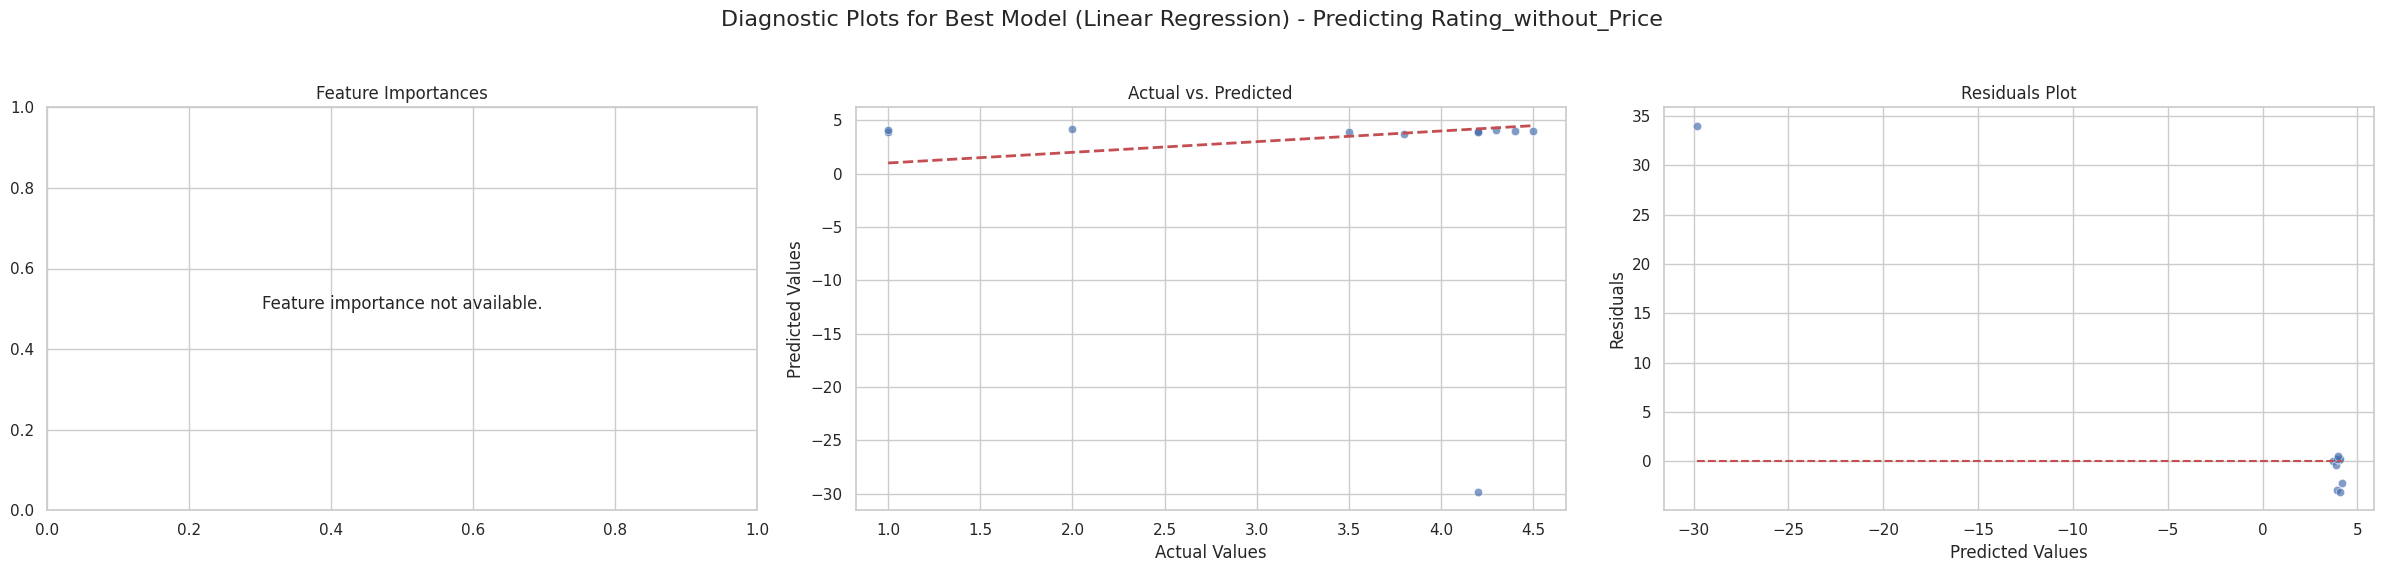


========================= Starting Full Analysis for: FRYER =========================

--- [EDA] Exploratory Analysis for fryer ---


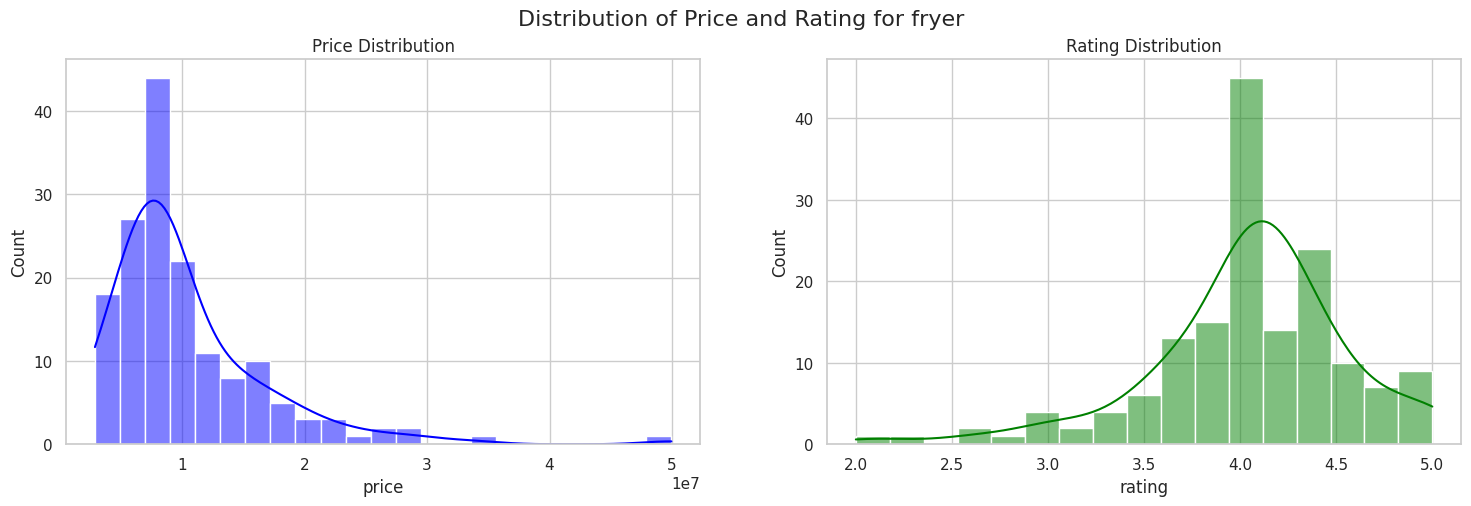

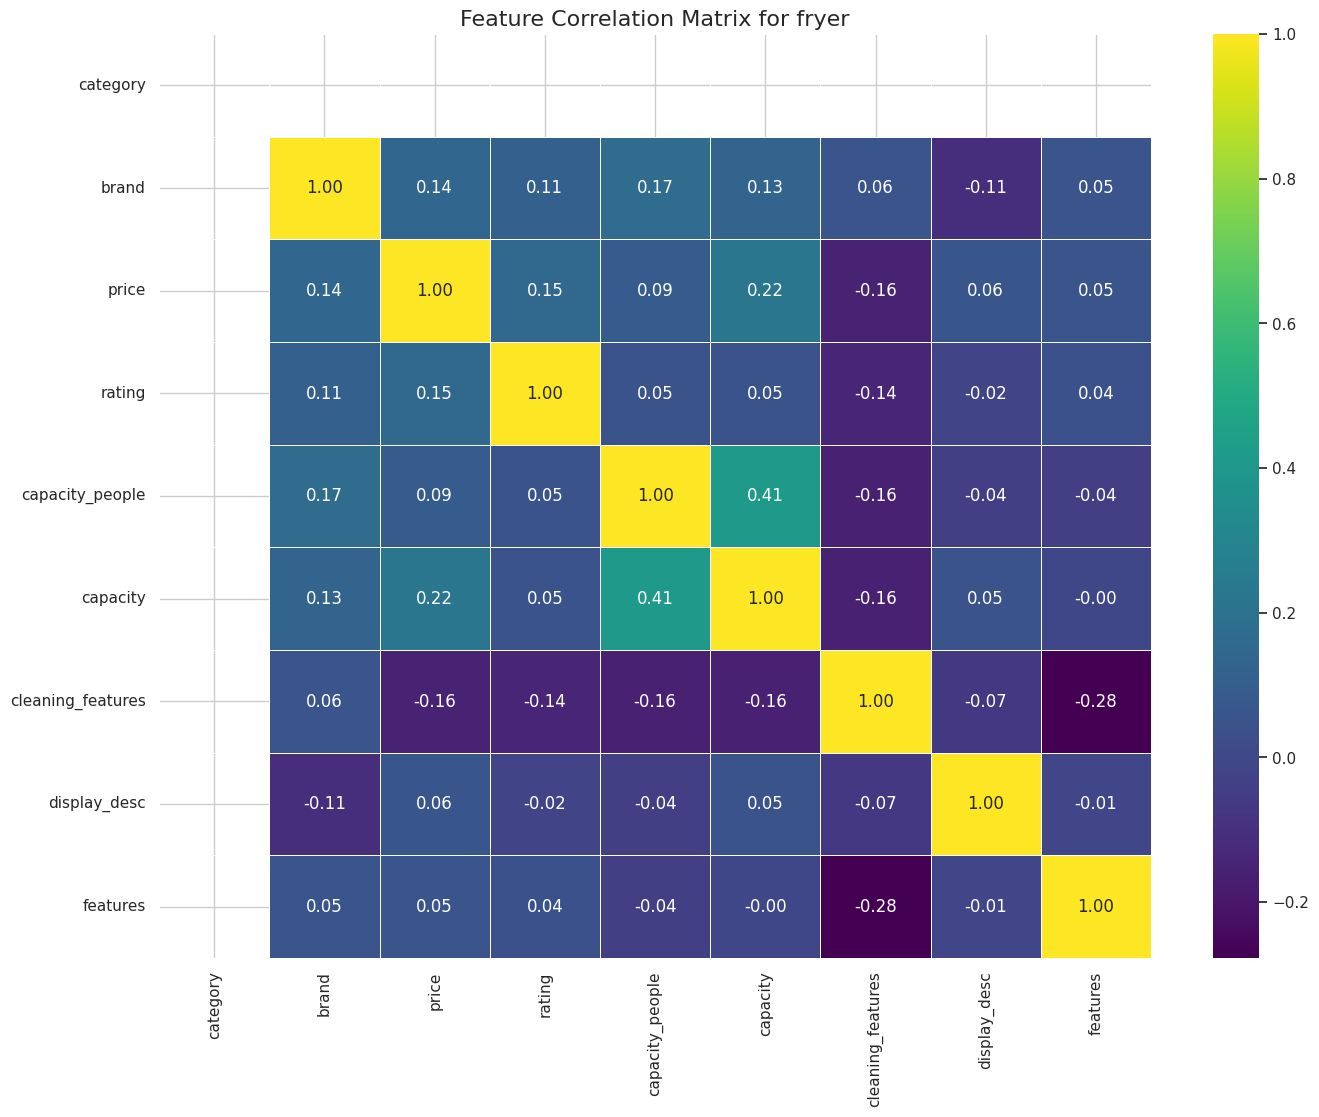


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Random Forest (R2: 4565408.8348)


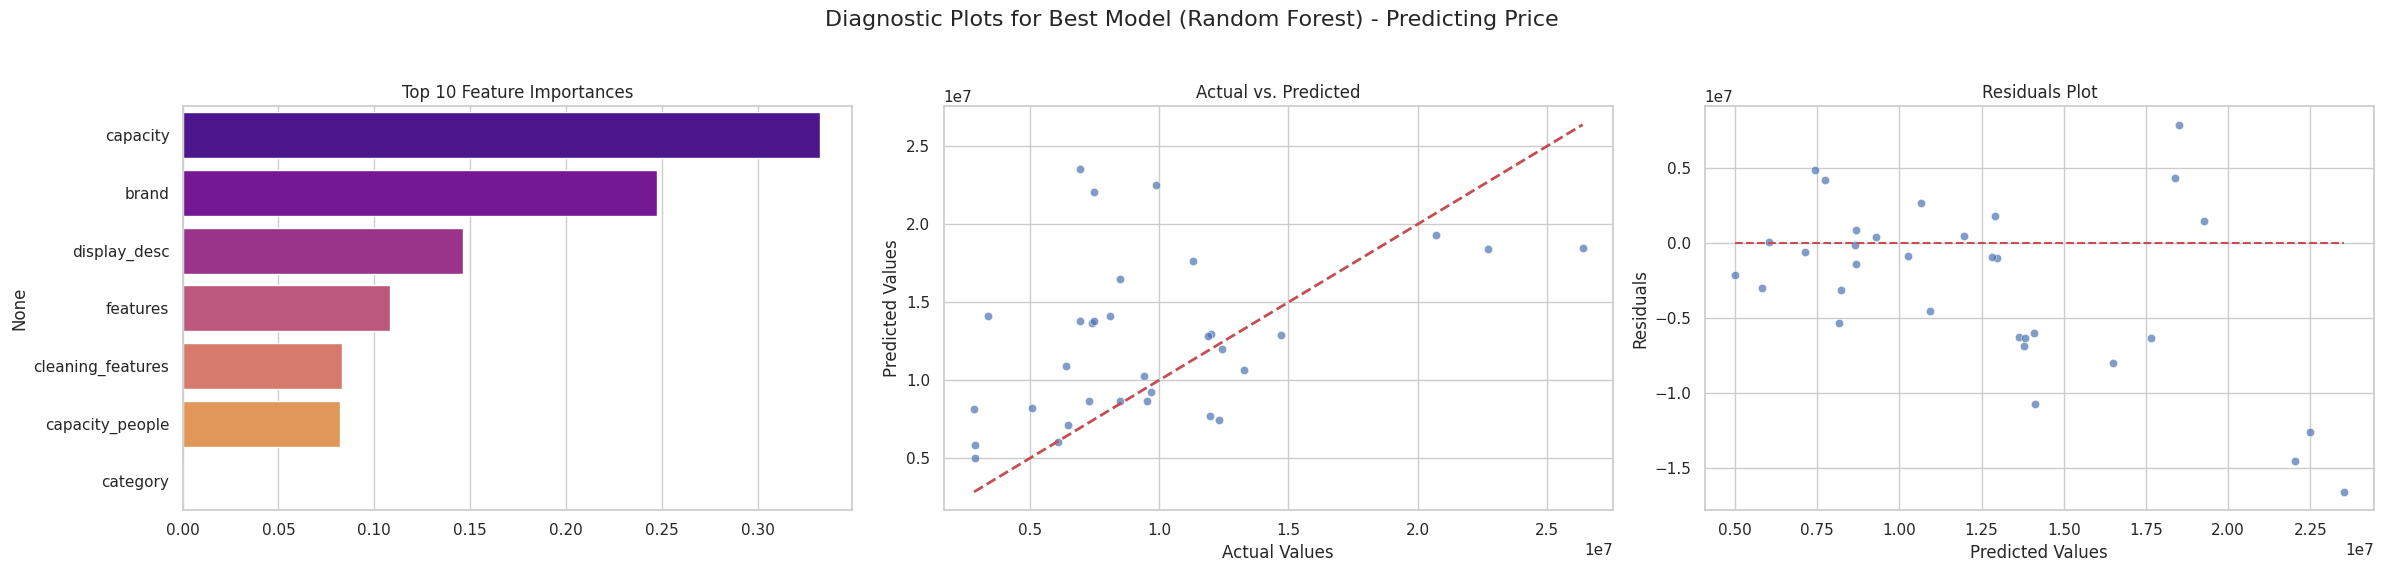


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: XGBoost (R2: 0.4180)


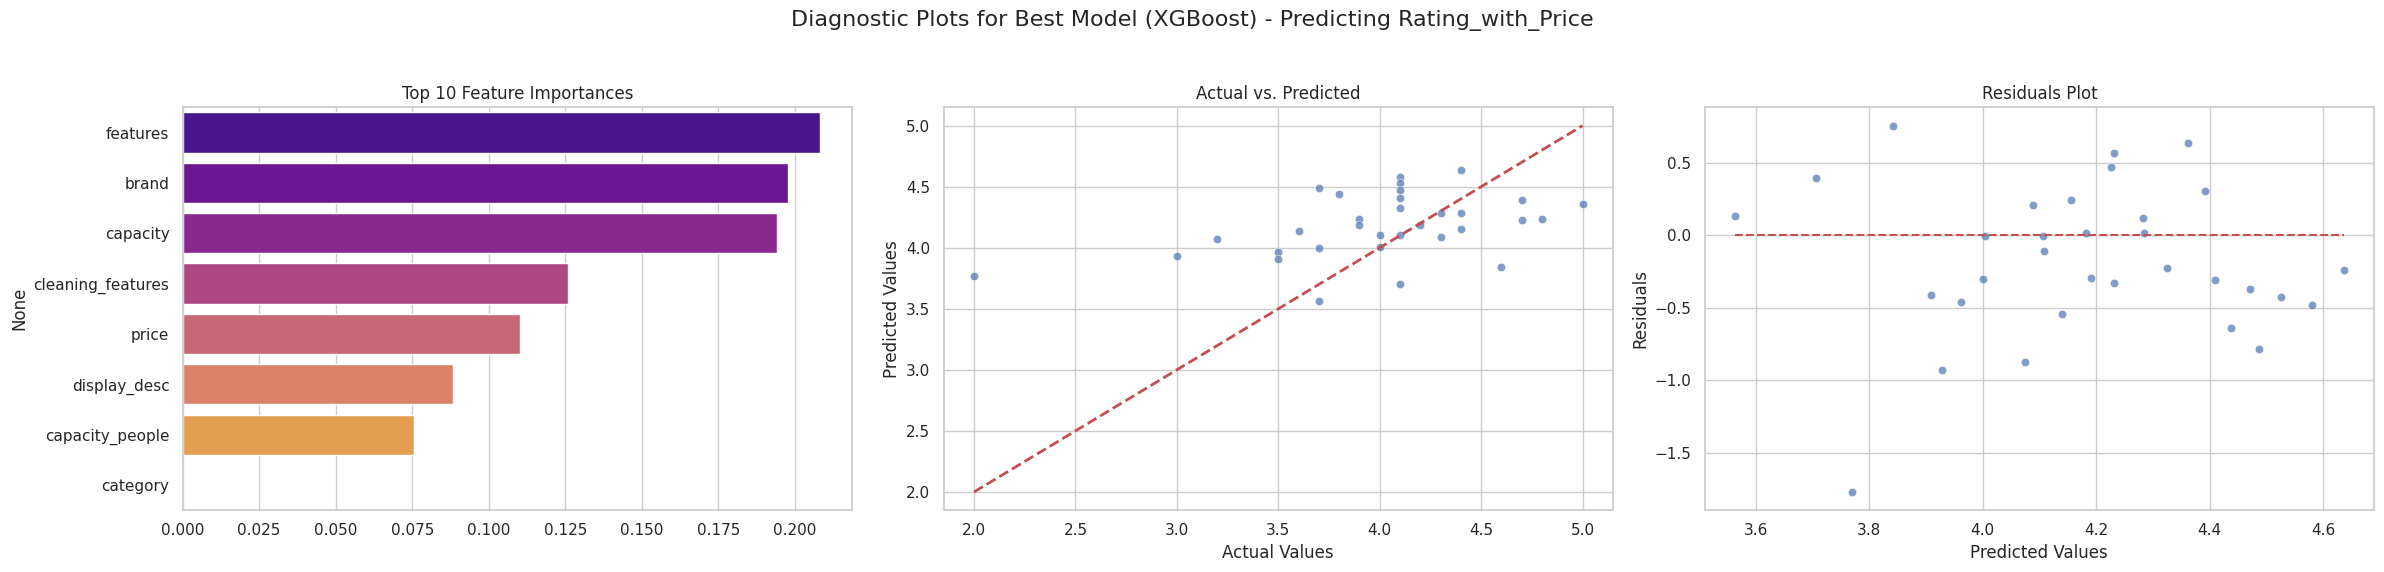


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.4489)


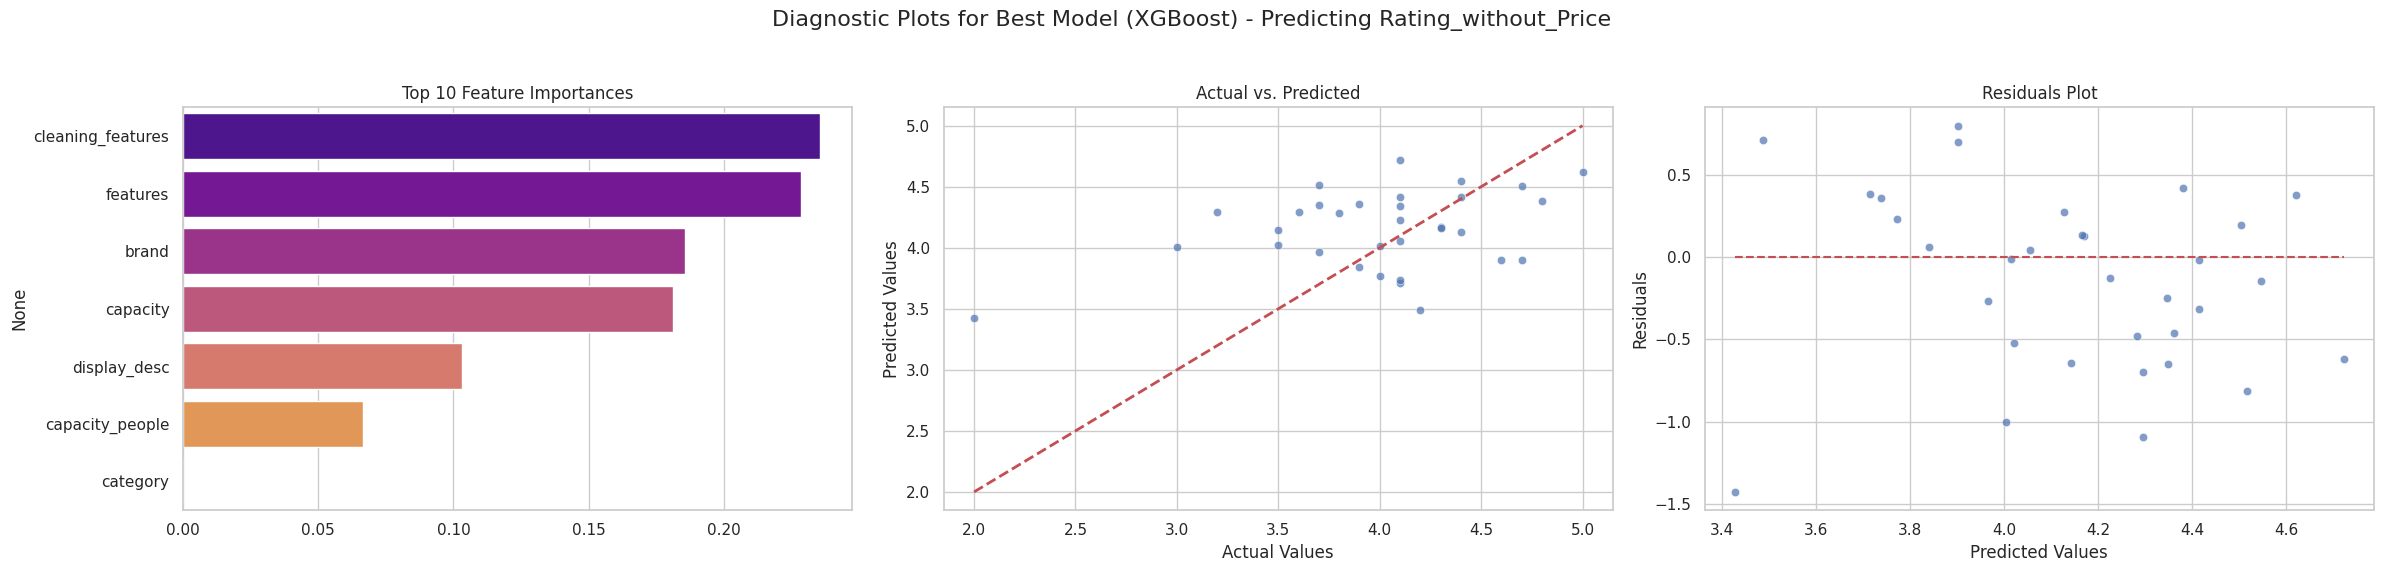


========================= Starting Full Analysis for: DISHWASHER =========================

--- [EDA] Exploratory Analysis for Dishwasher ---


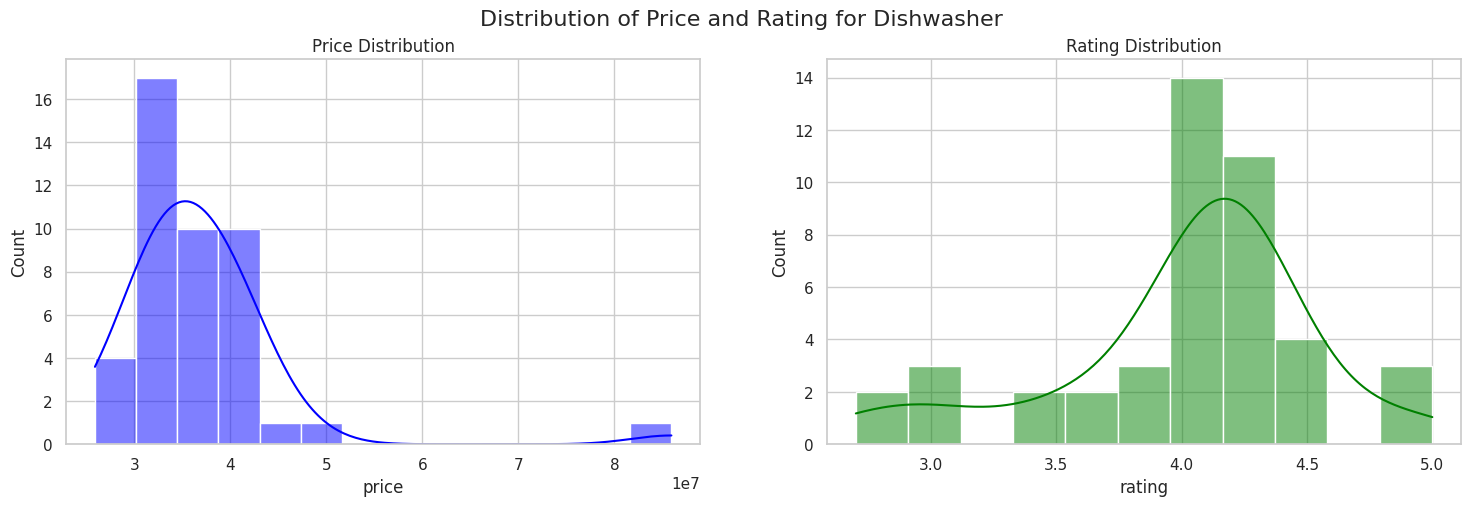

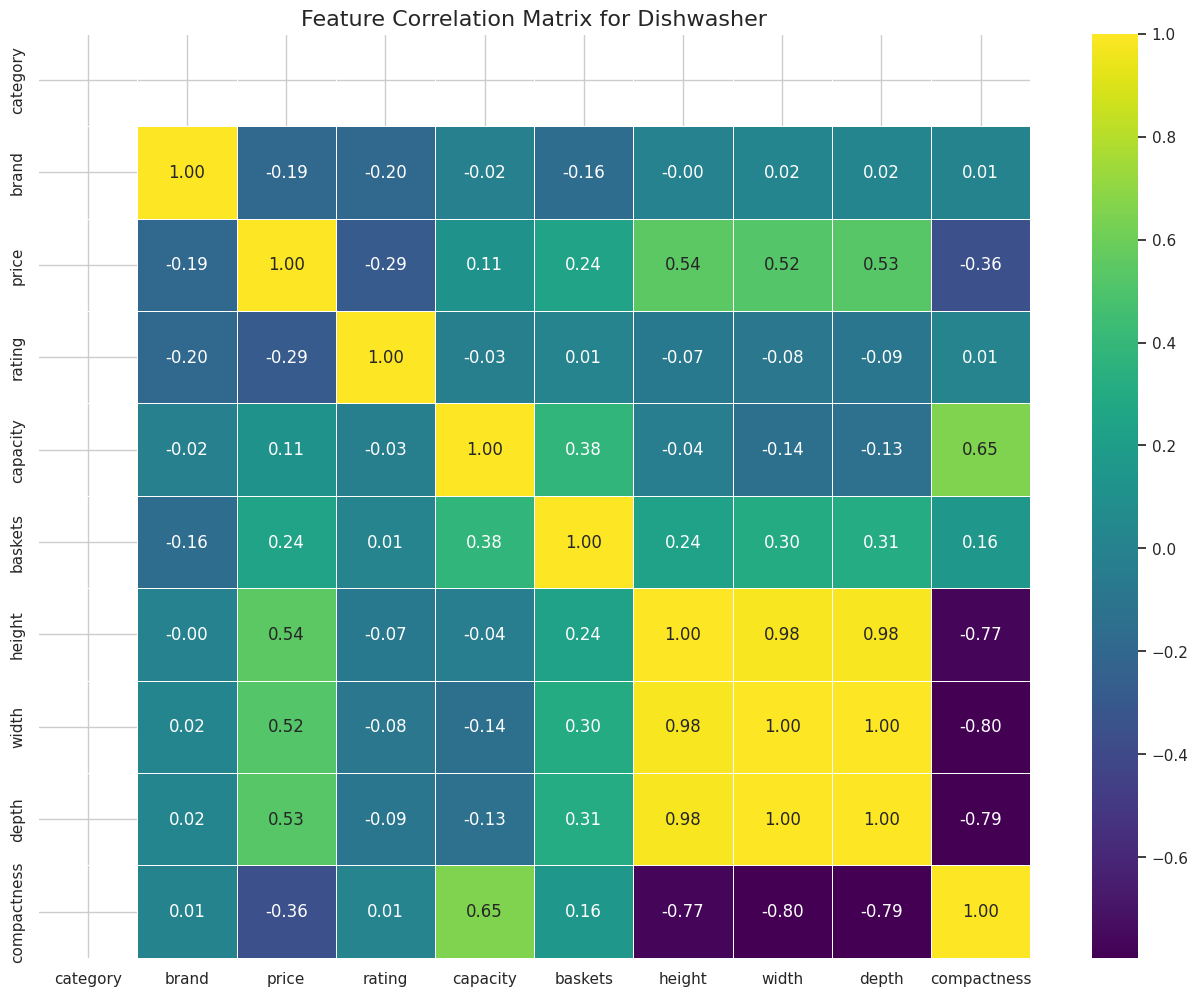


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 8330334.0667)


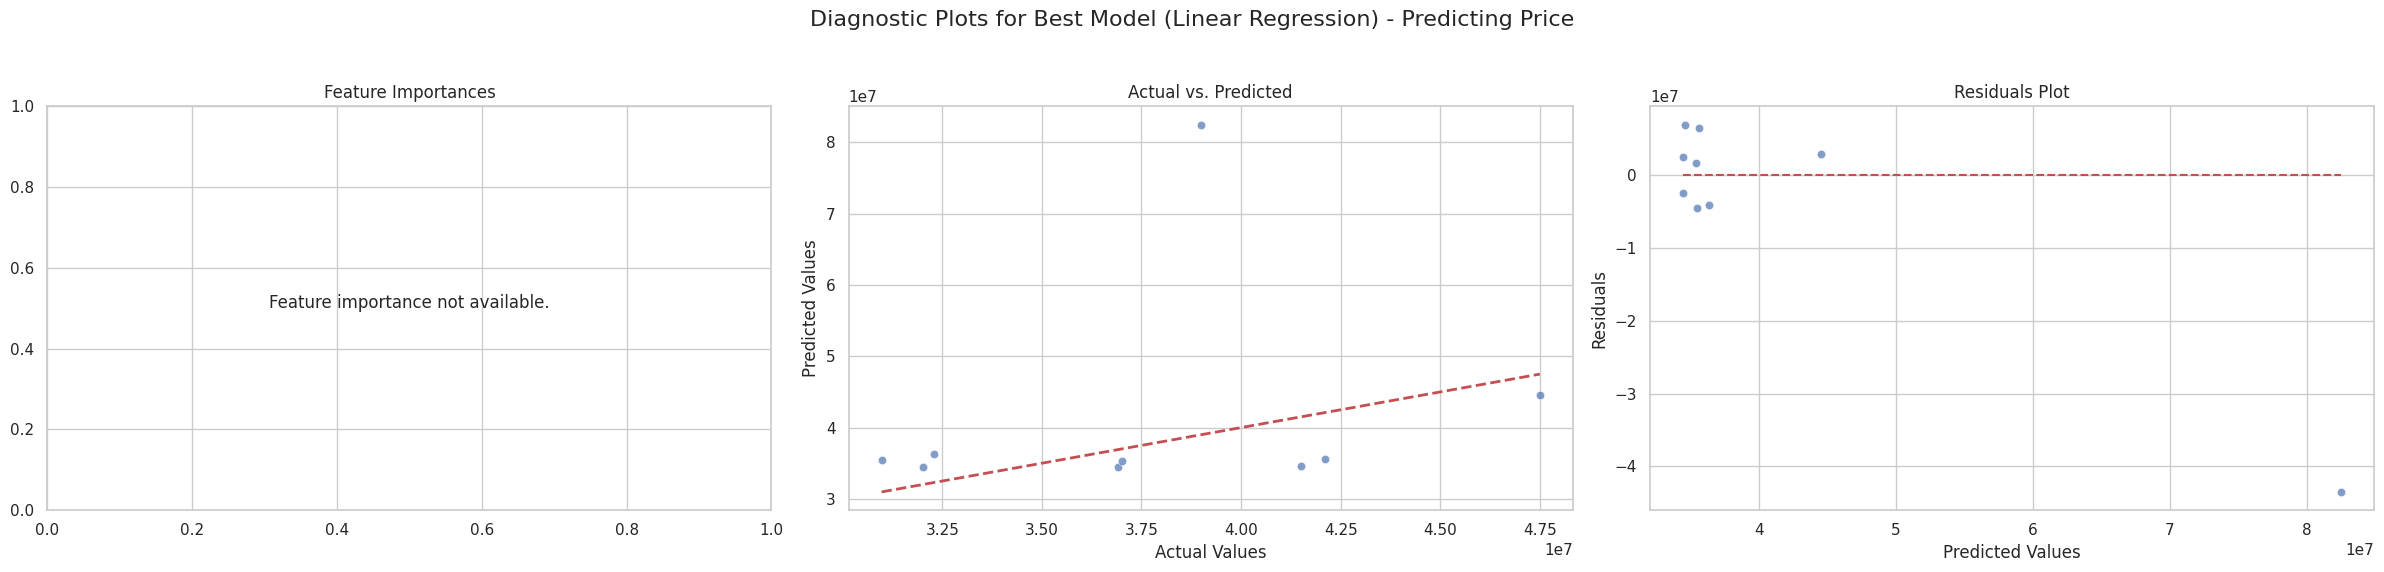


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: XGBoost (R2: 0.6429)


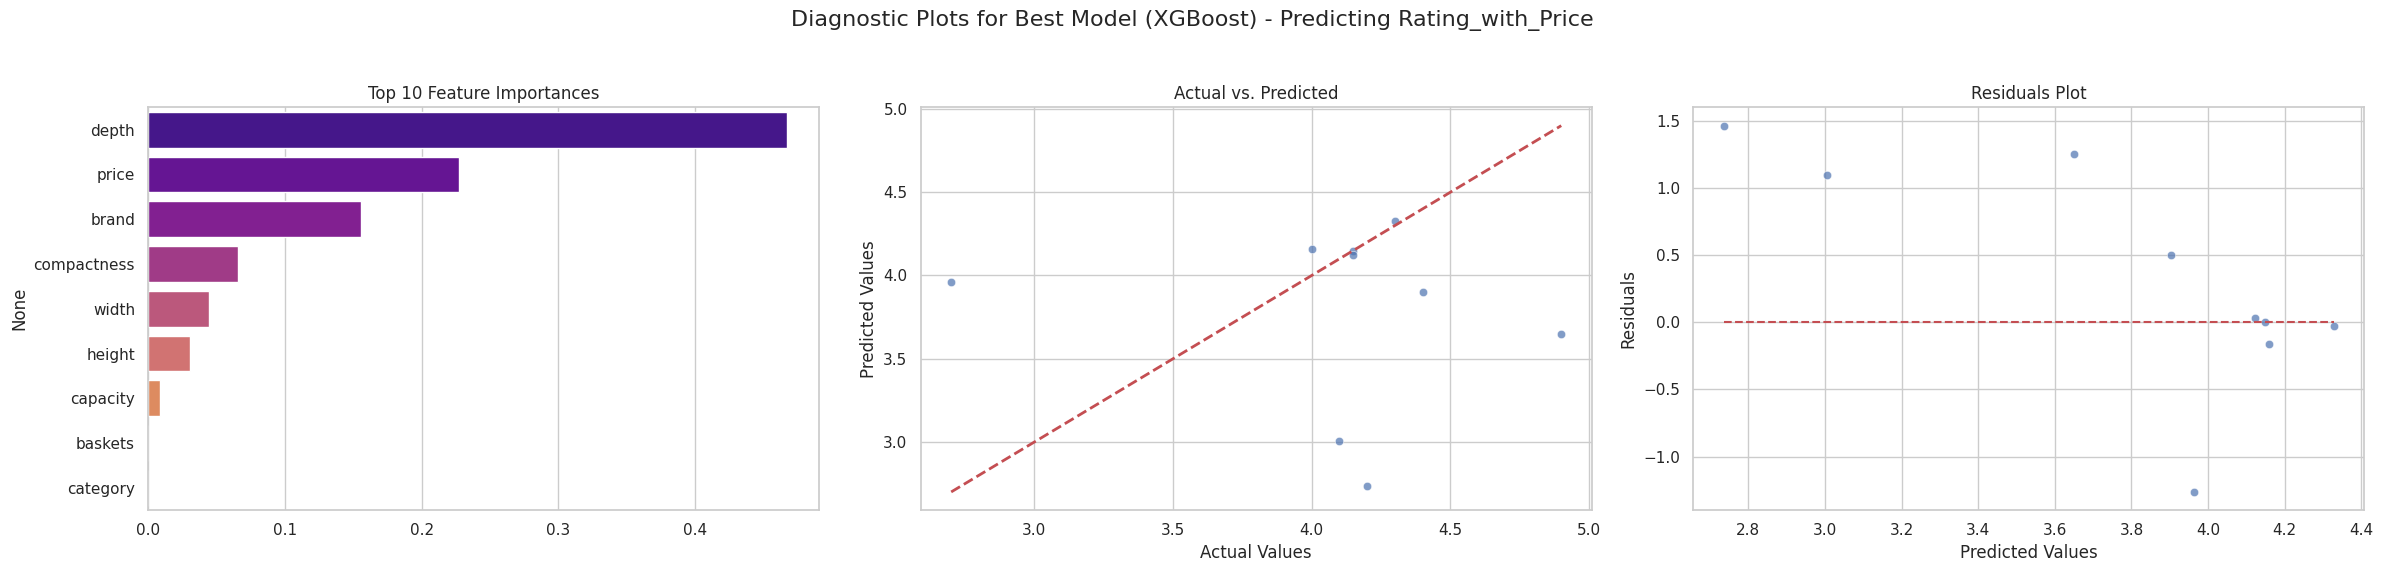


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.6507)


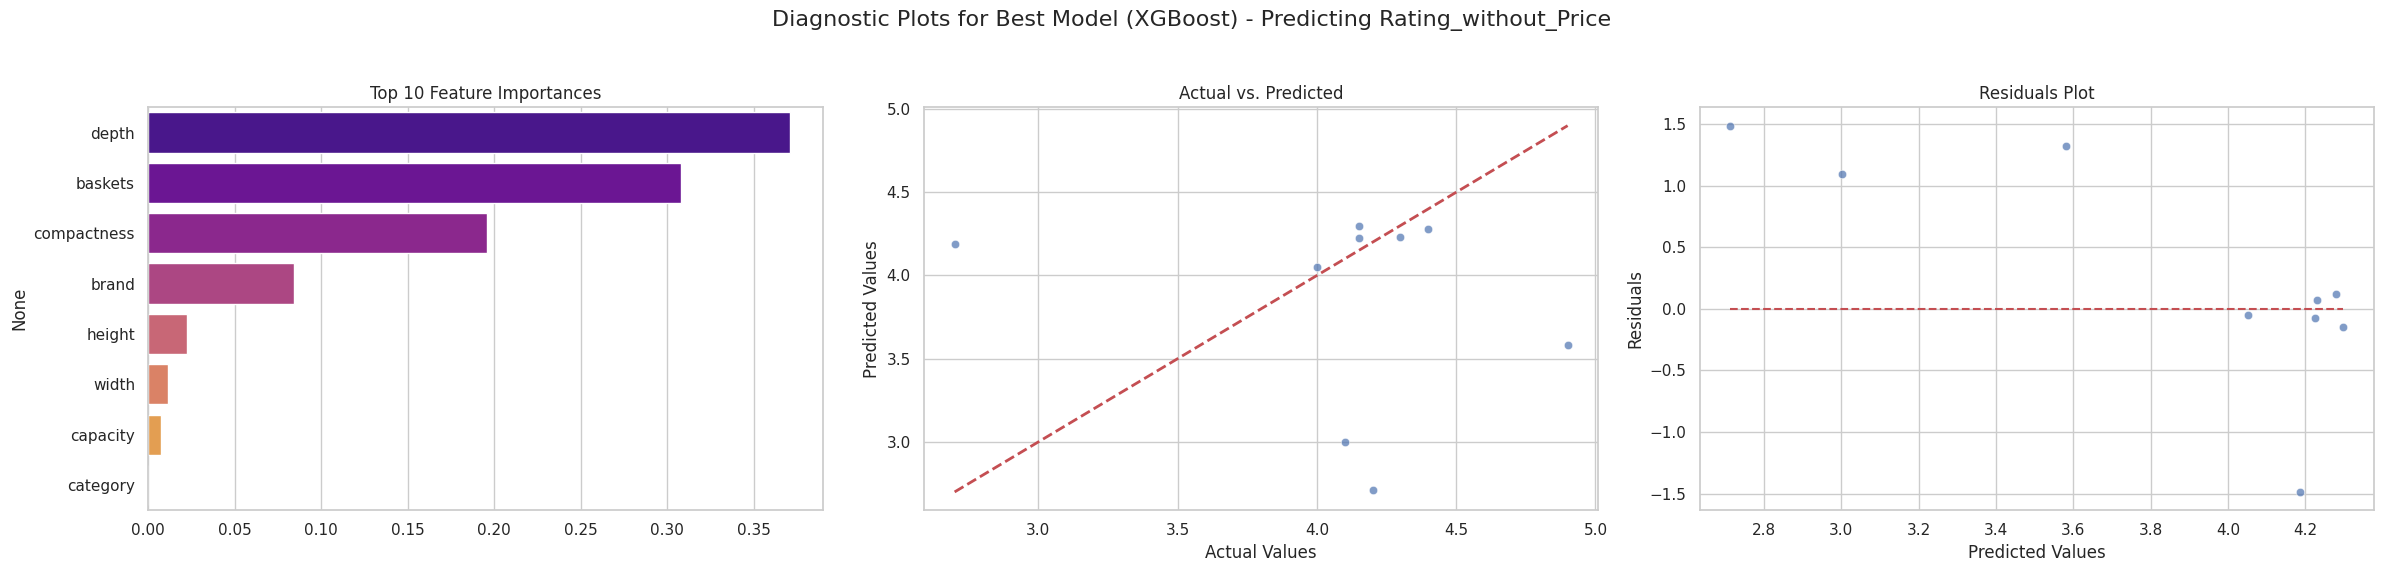


========================= Starting Full Analysis for: WASHING_MACHINE =========================

--- [EDA] Exploratory Analysis for Washing_machine ---


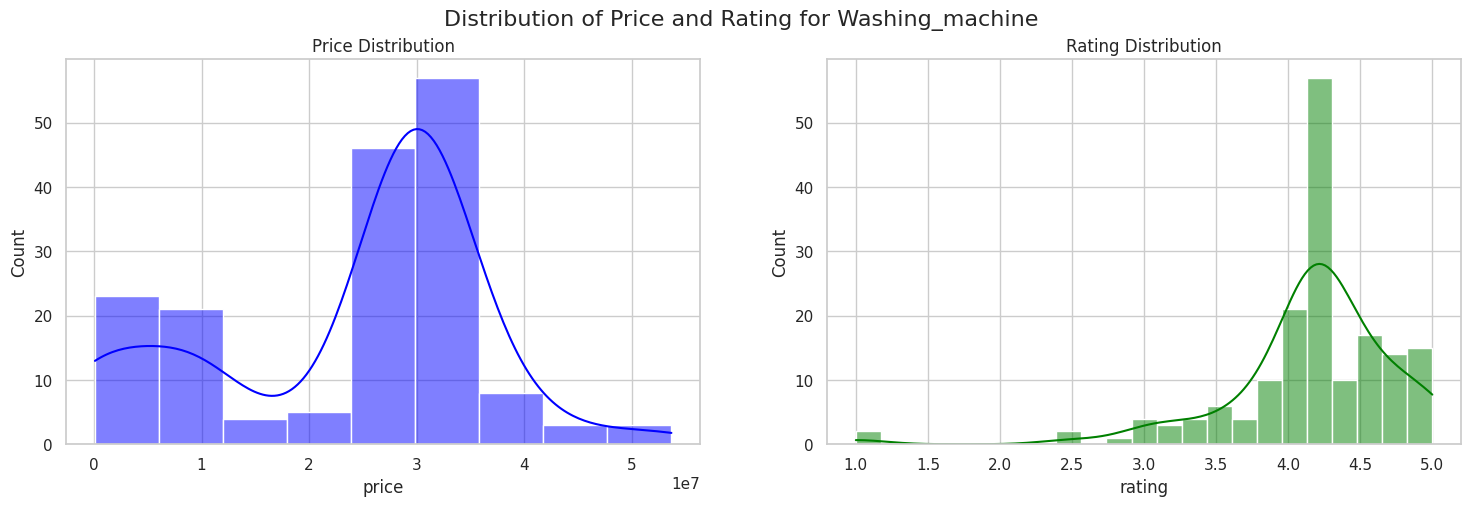

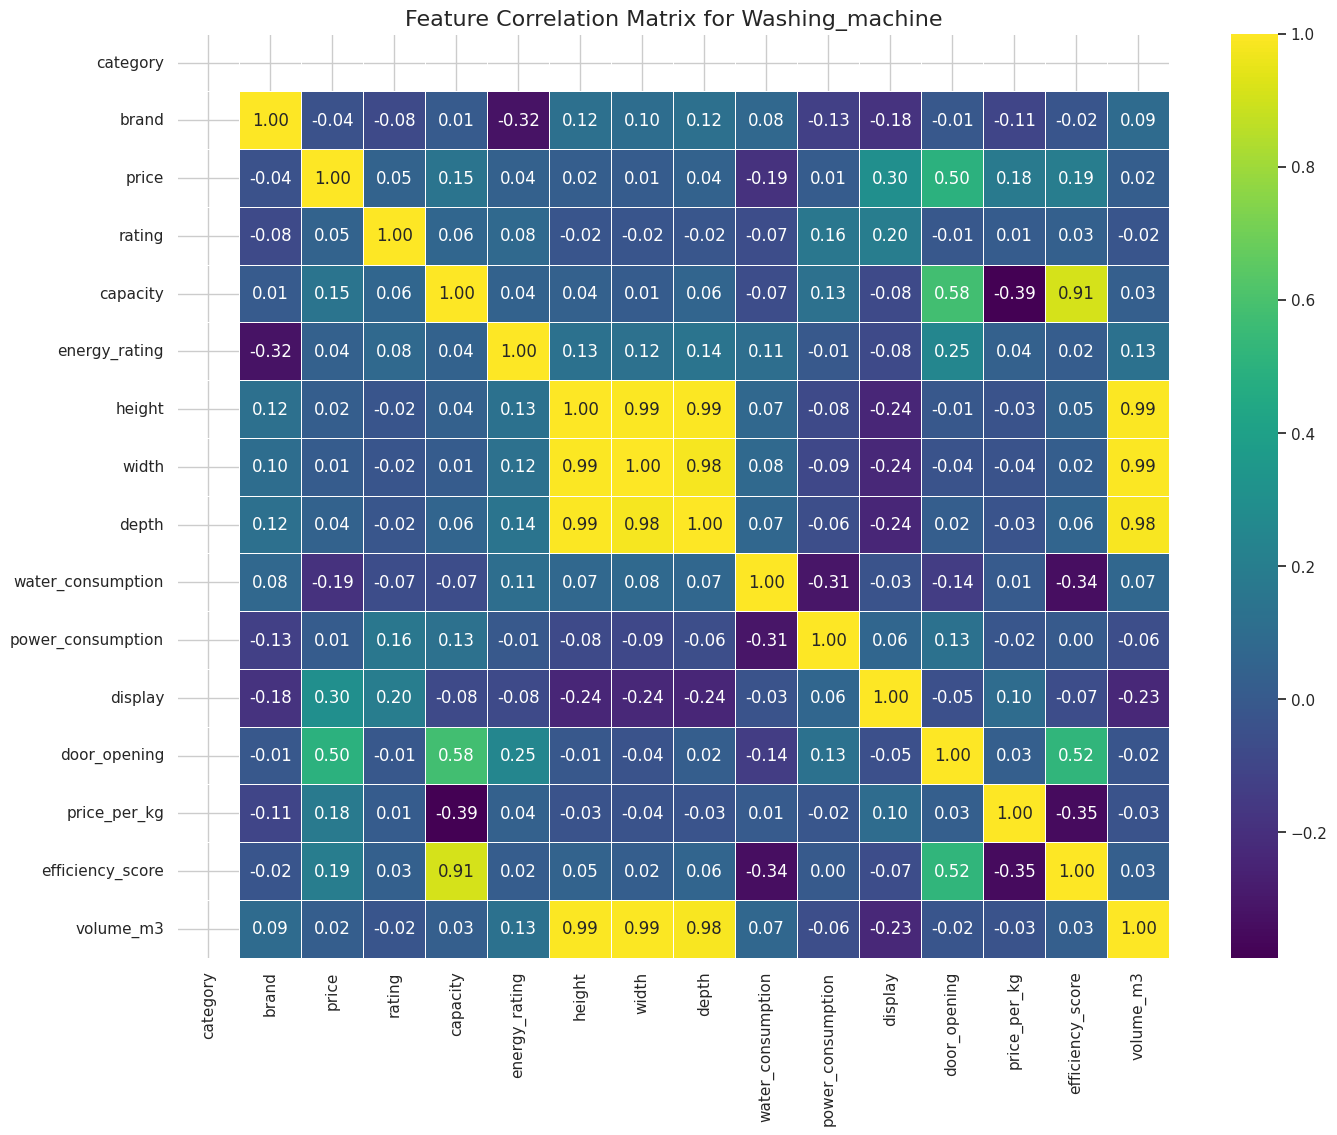


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 19627861.4710)


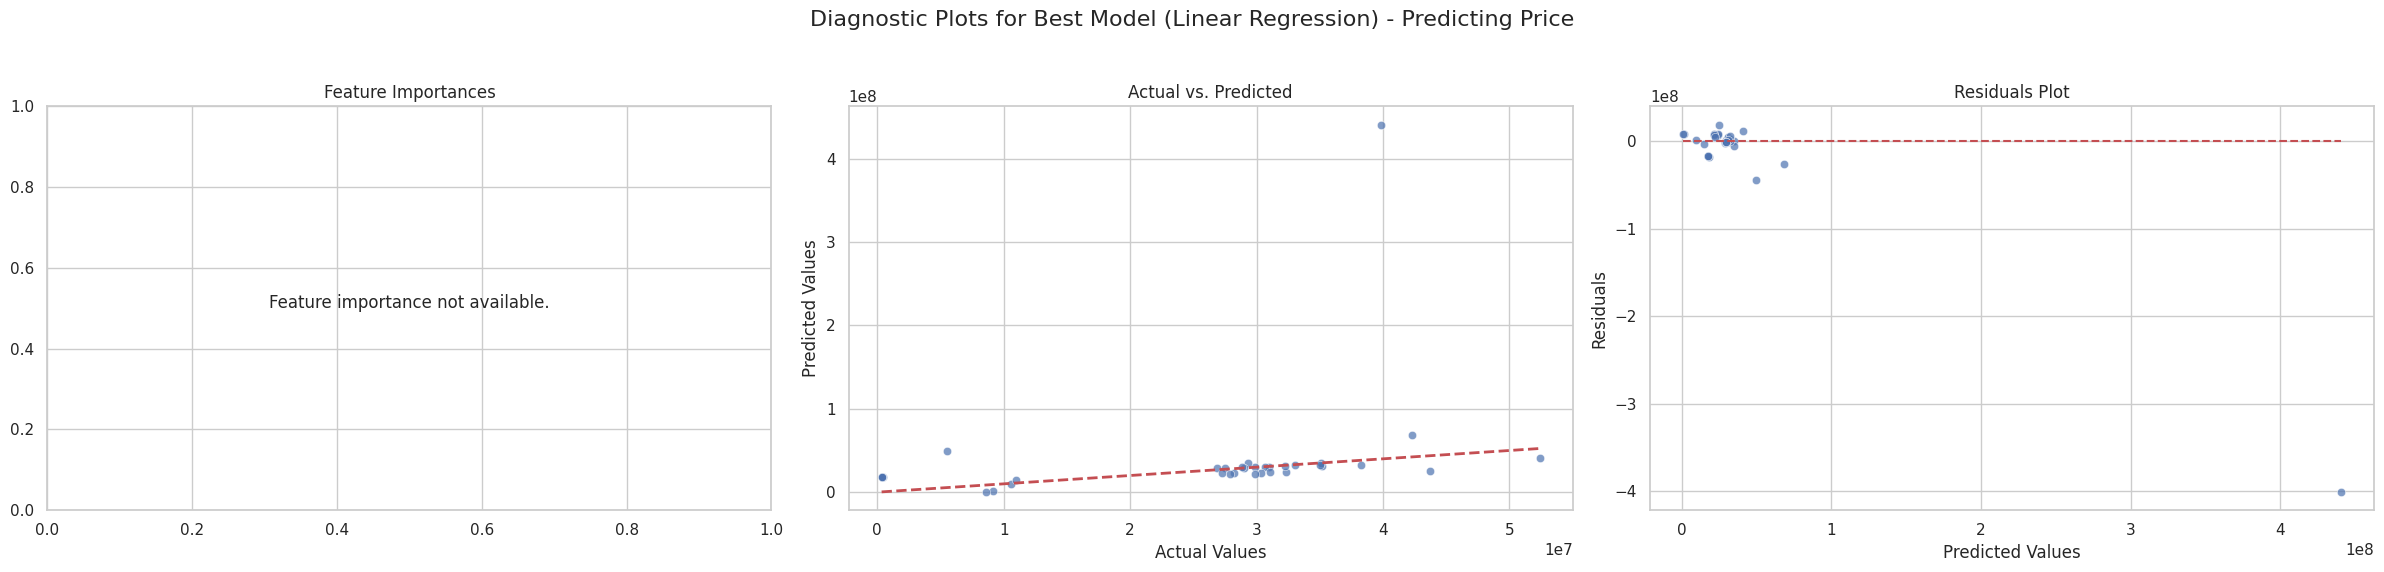


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: Random Forest (R2: 0.5662)


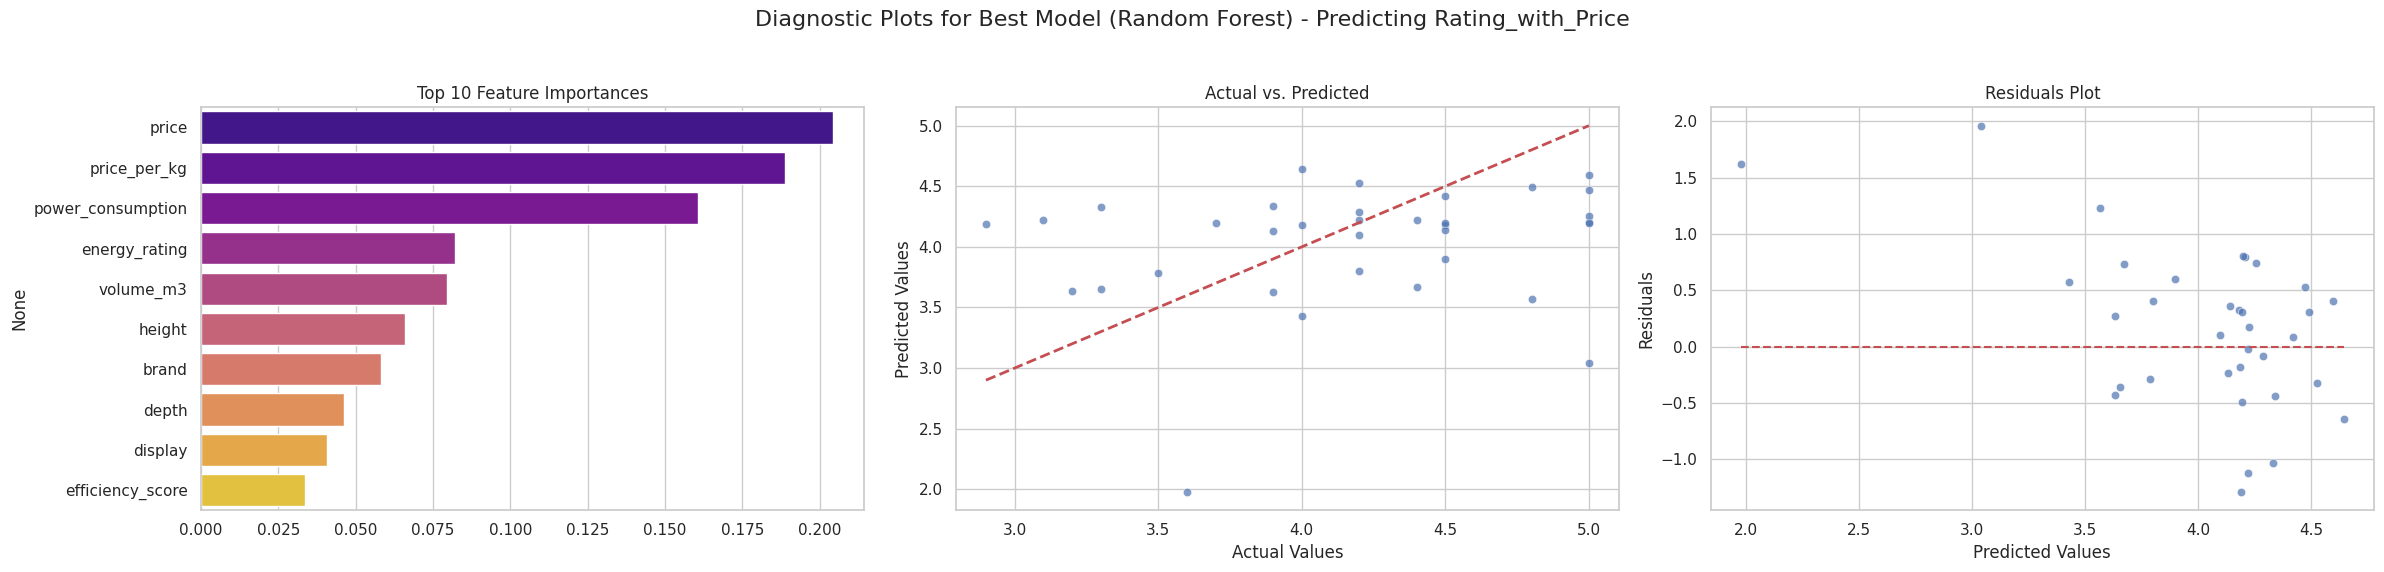


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.5722)


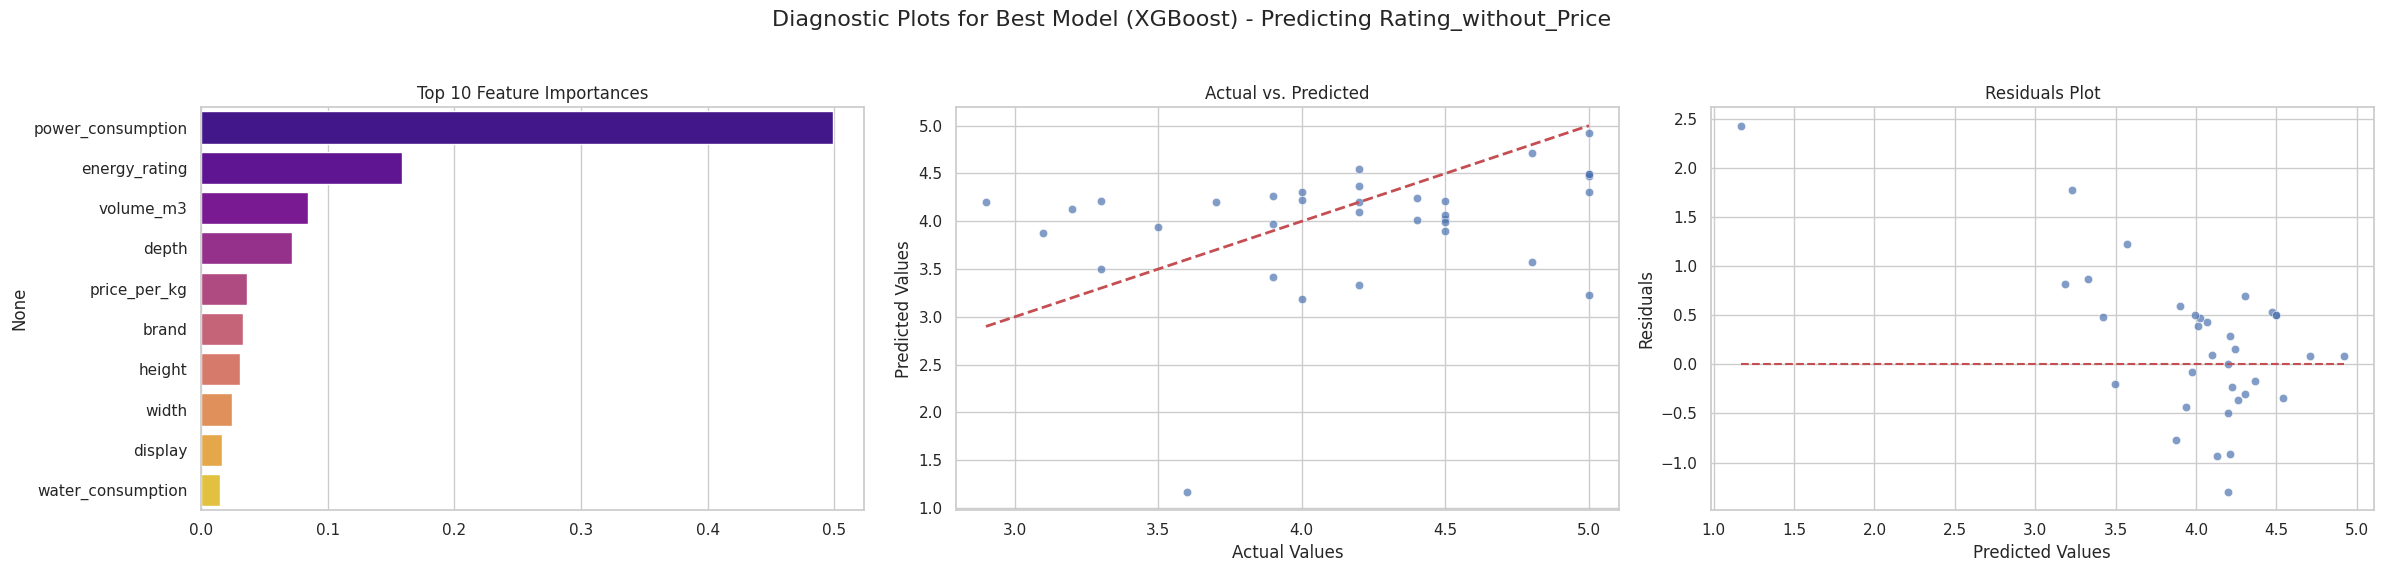


========================= Starting Full Analysis for: STIRRER =========================

--- [EDA] Exploratory Analysis for Stirrer ---


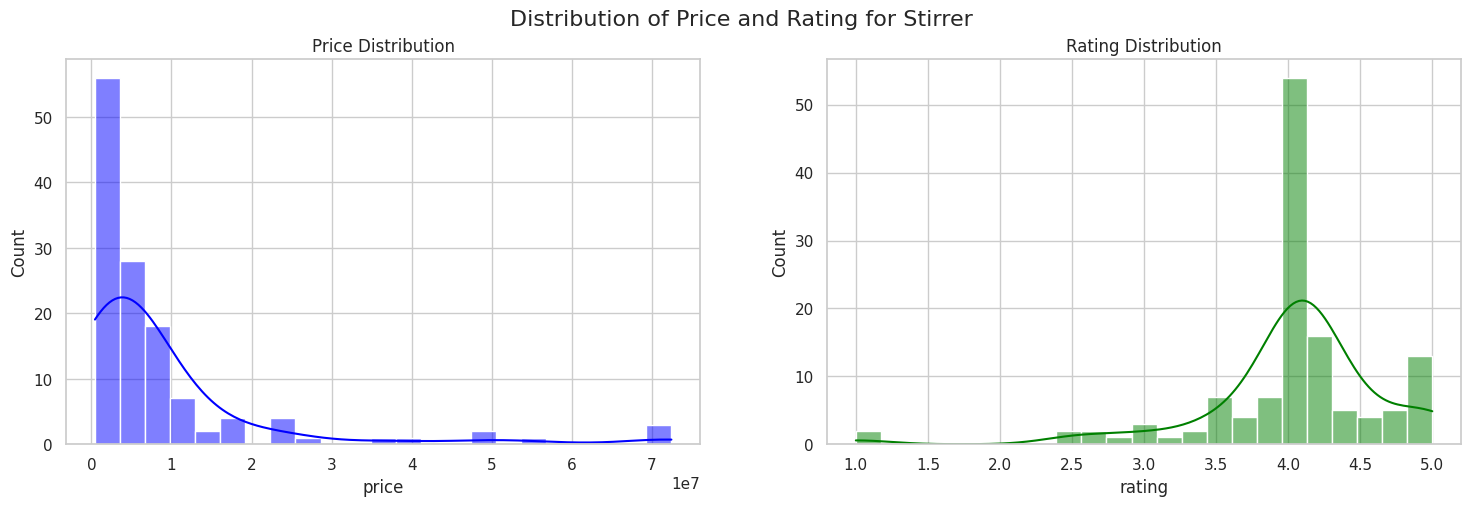

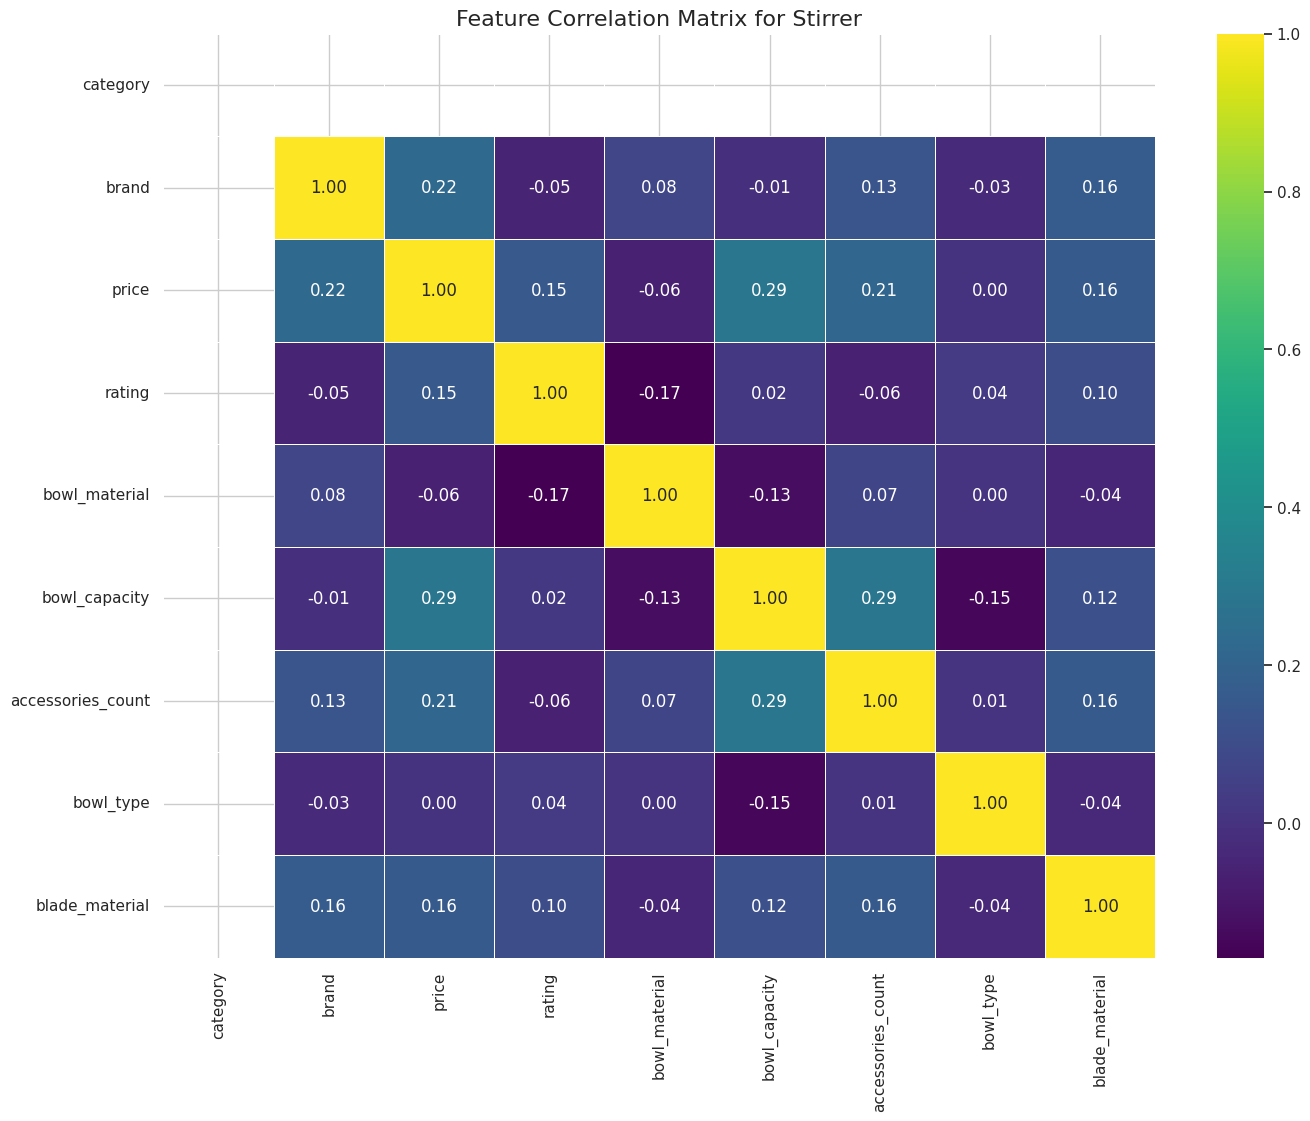


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 8441613.2619)


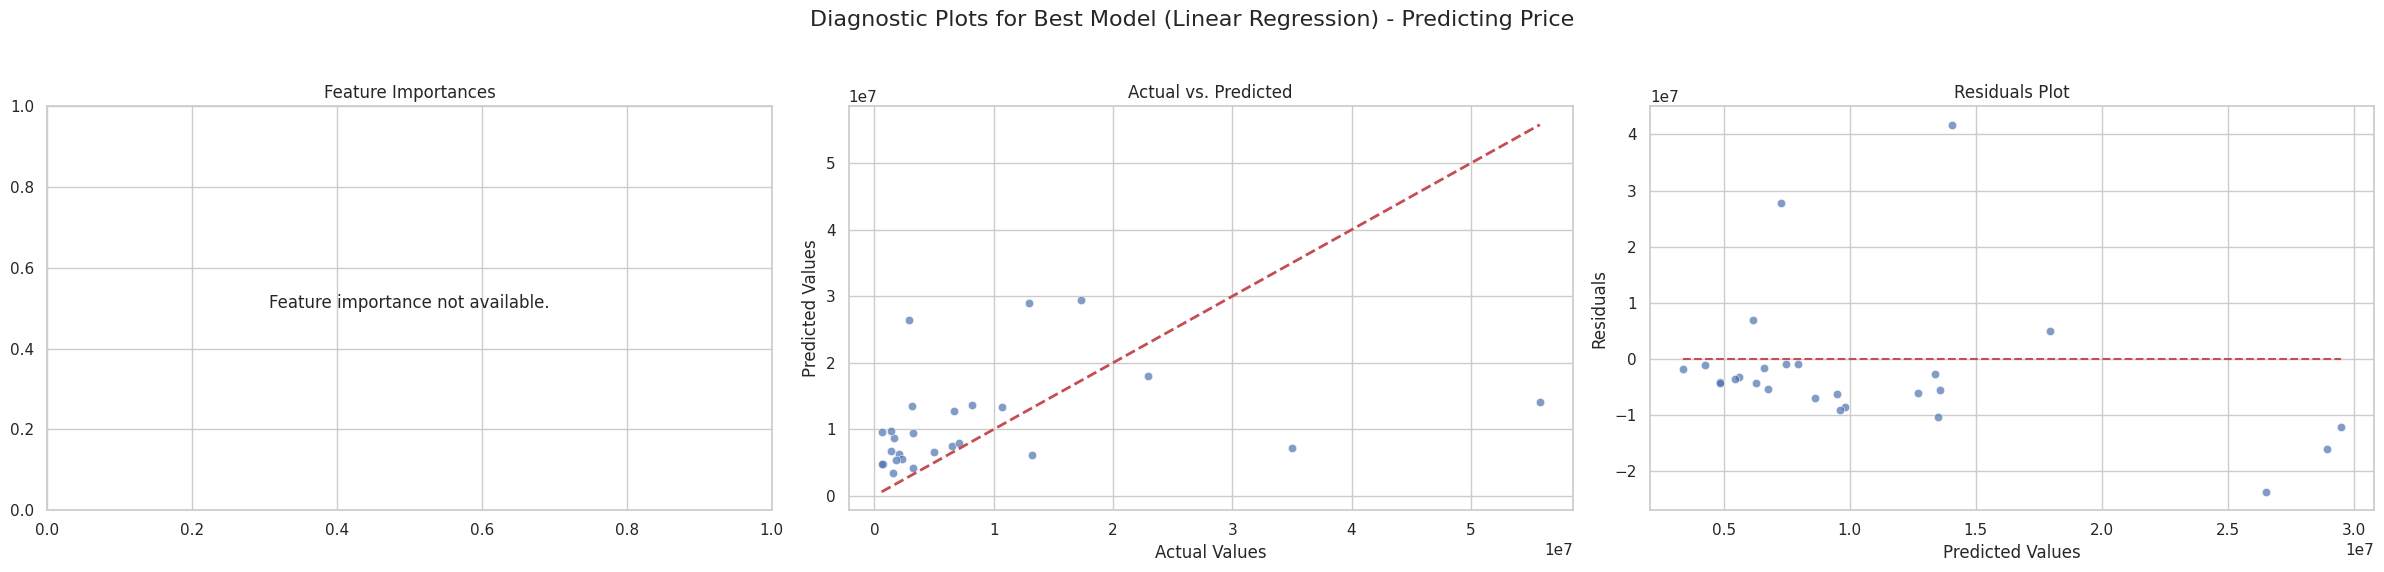


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: Linear Regression (R2: 0.4730)


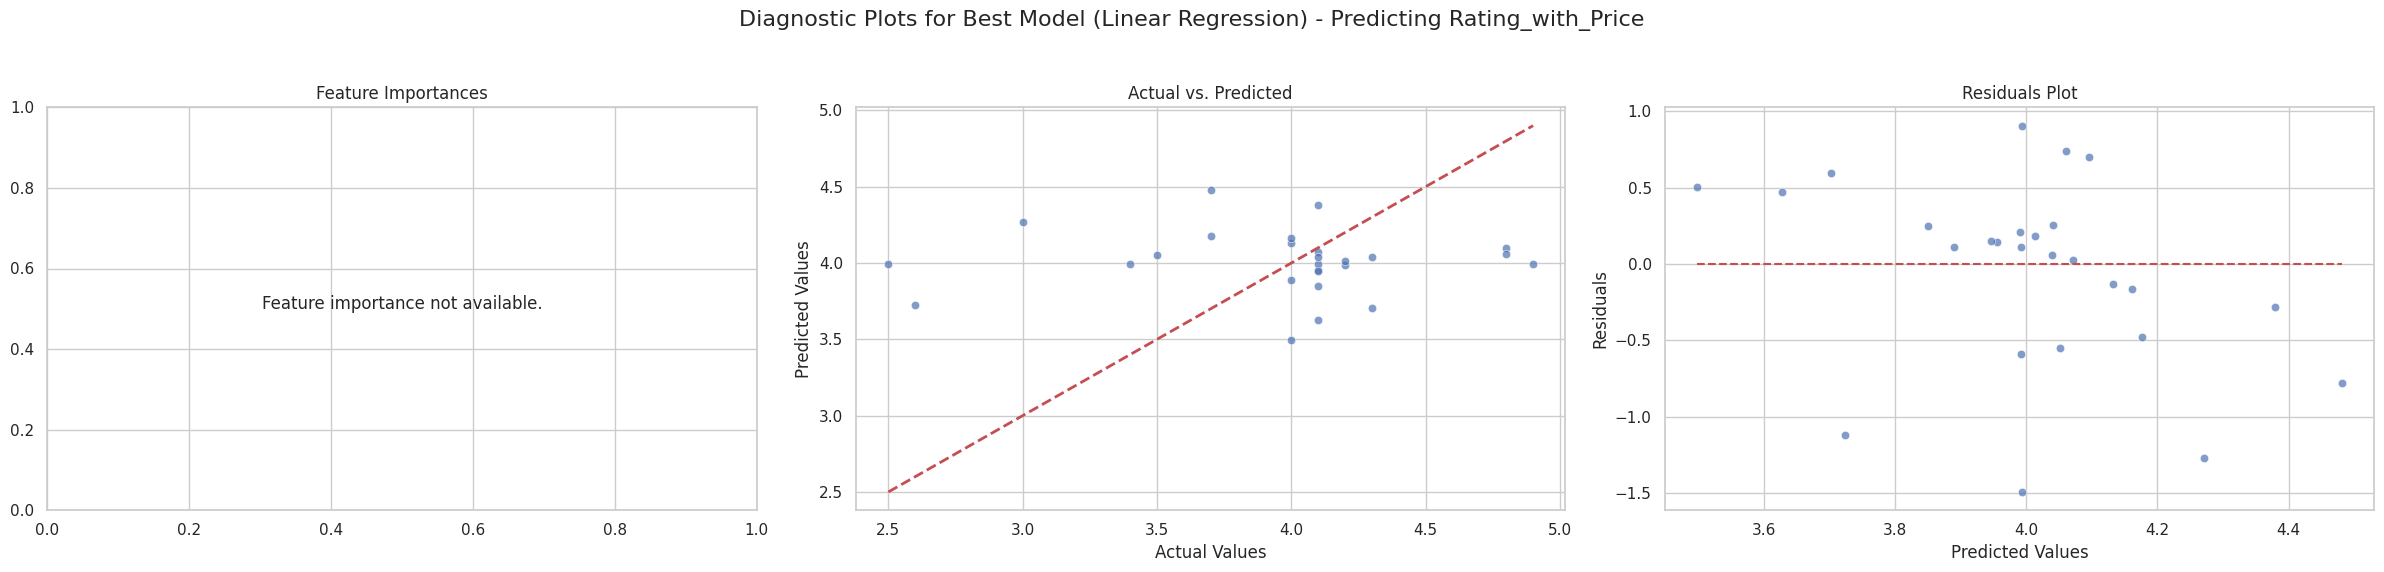


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: XGBoost (R2: 0.5896)


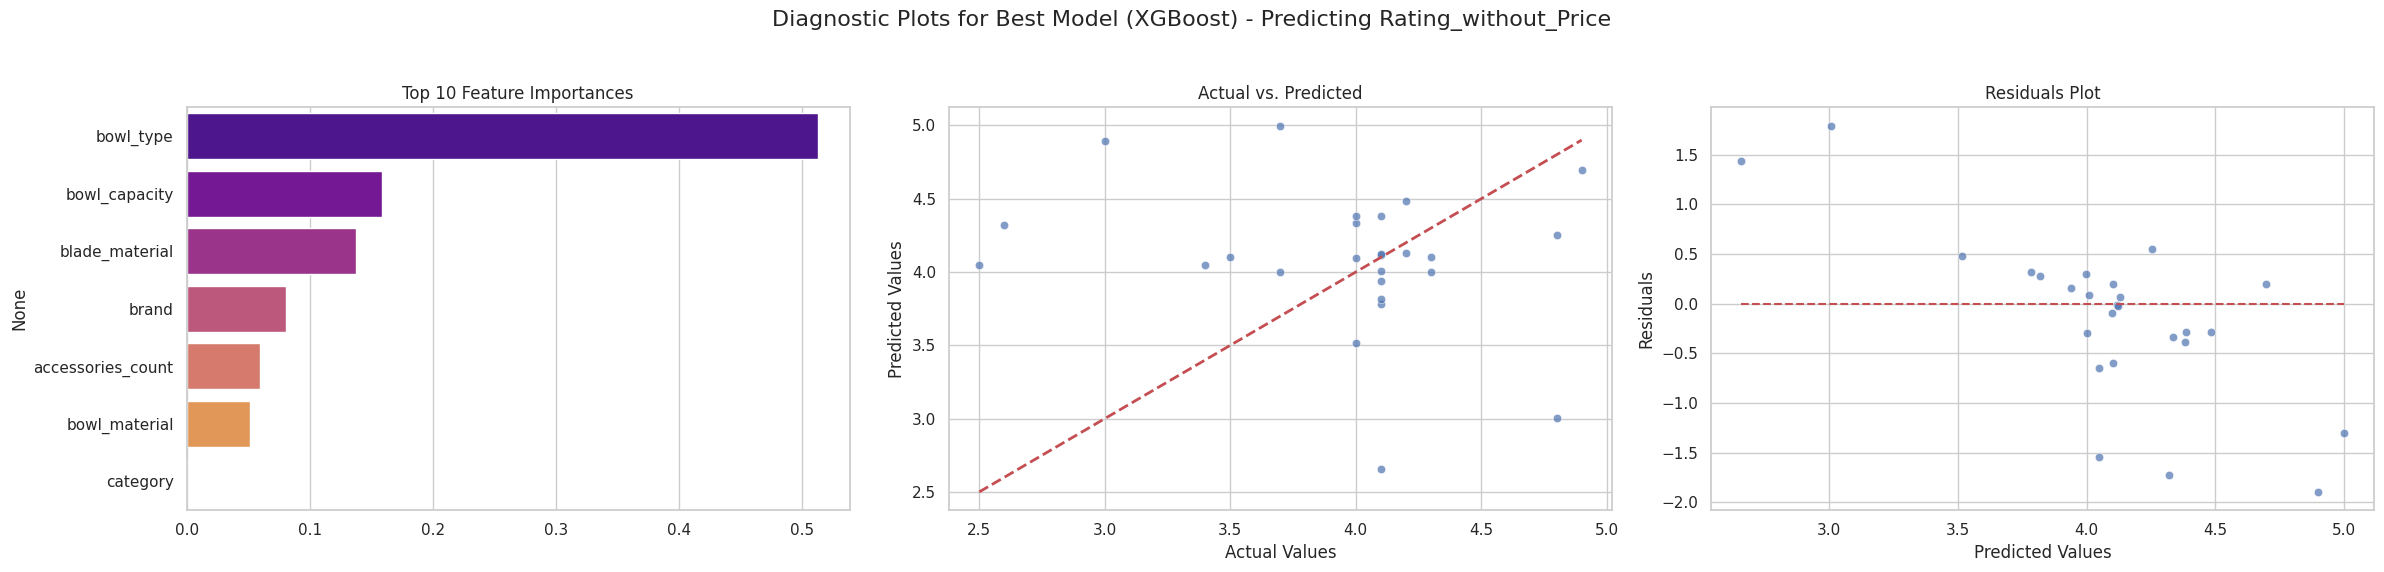


========================= Starting Full Analysis for: REFRIGERATOR =========================

--- [EDA] Exploratory Analysis for Refrigerator ---


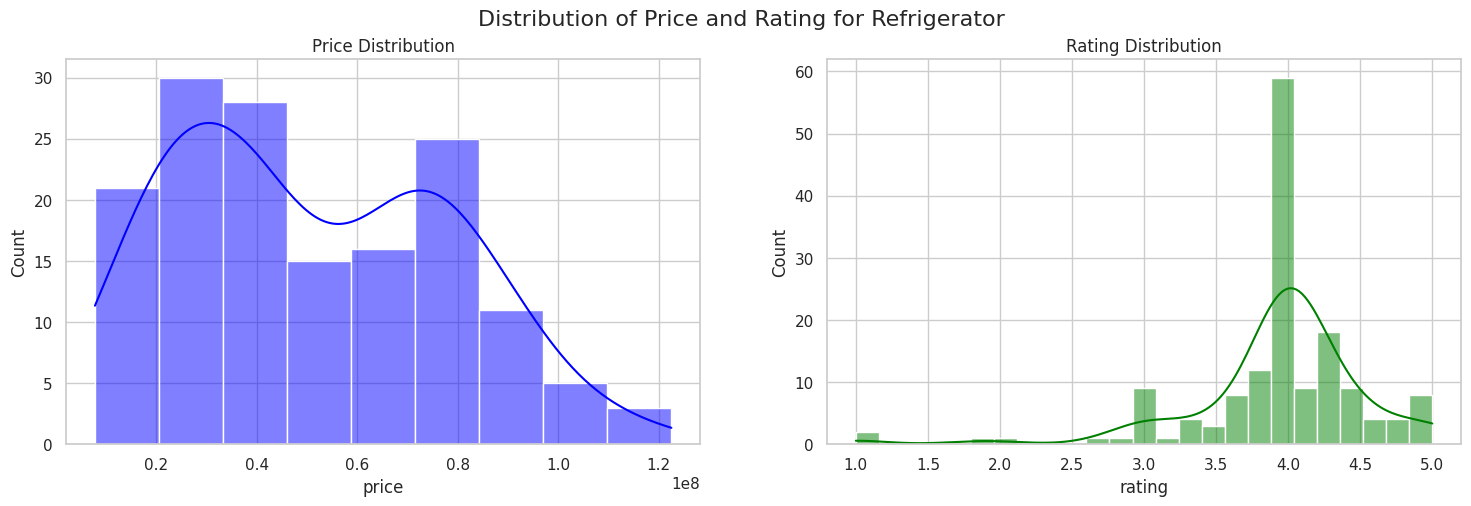

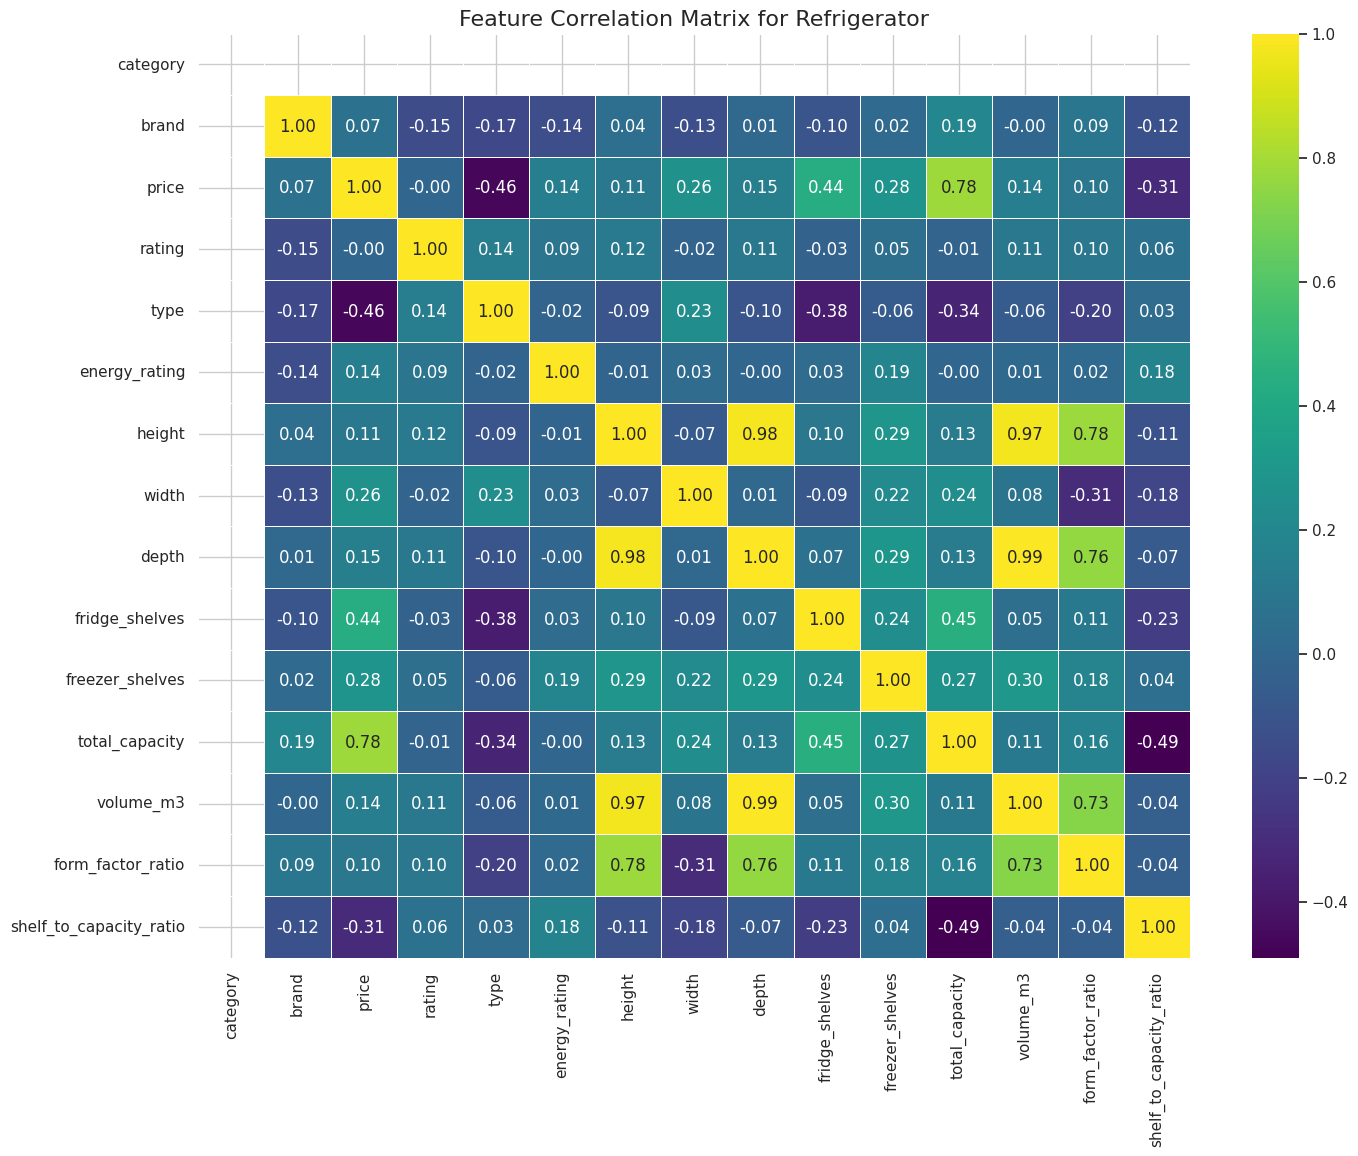


--- Running Experiment: Predicting Price ---
  -> Best Model Found: Linear Regression (R2: 39337334.0766)


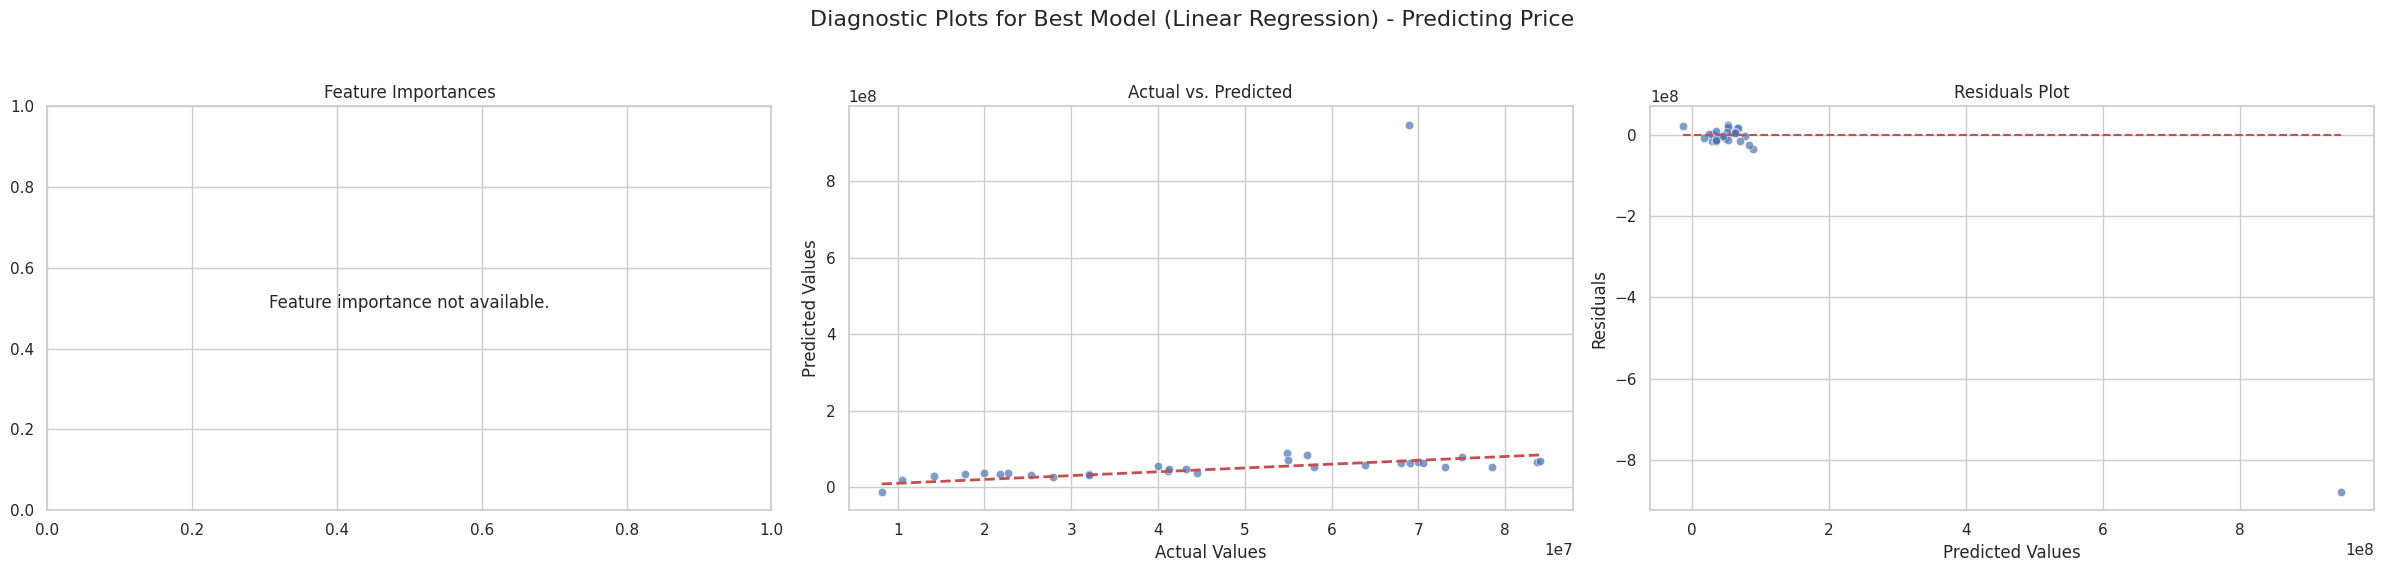


--- Running Experiment: Predicting Rating_with_Price ---
  -> Best Model Found: XGBoost (R2: 0.5522)


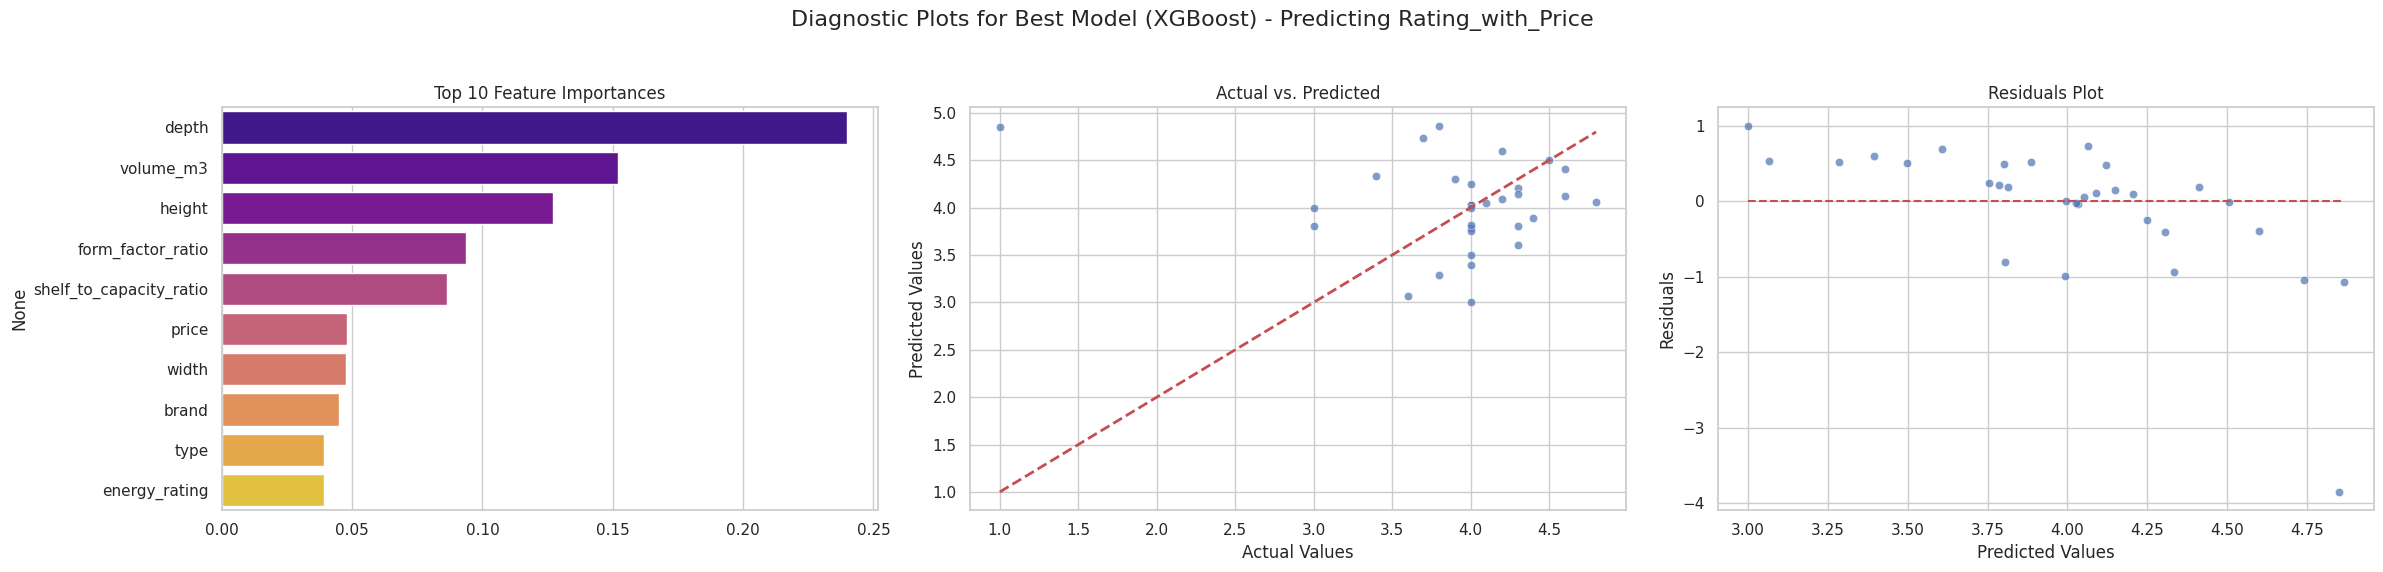


--- Running Experiment: Predicting Rating_without_Price ---
  -> Best Model Found: Linear Regression (R2: 0.6704)


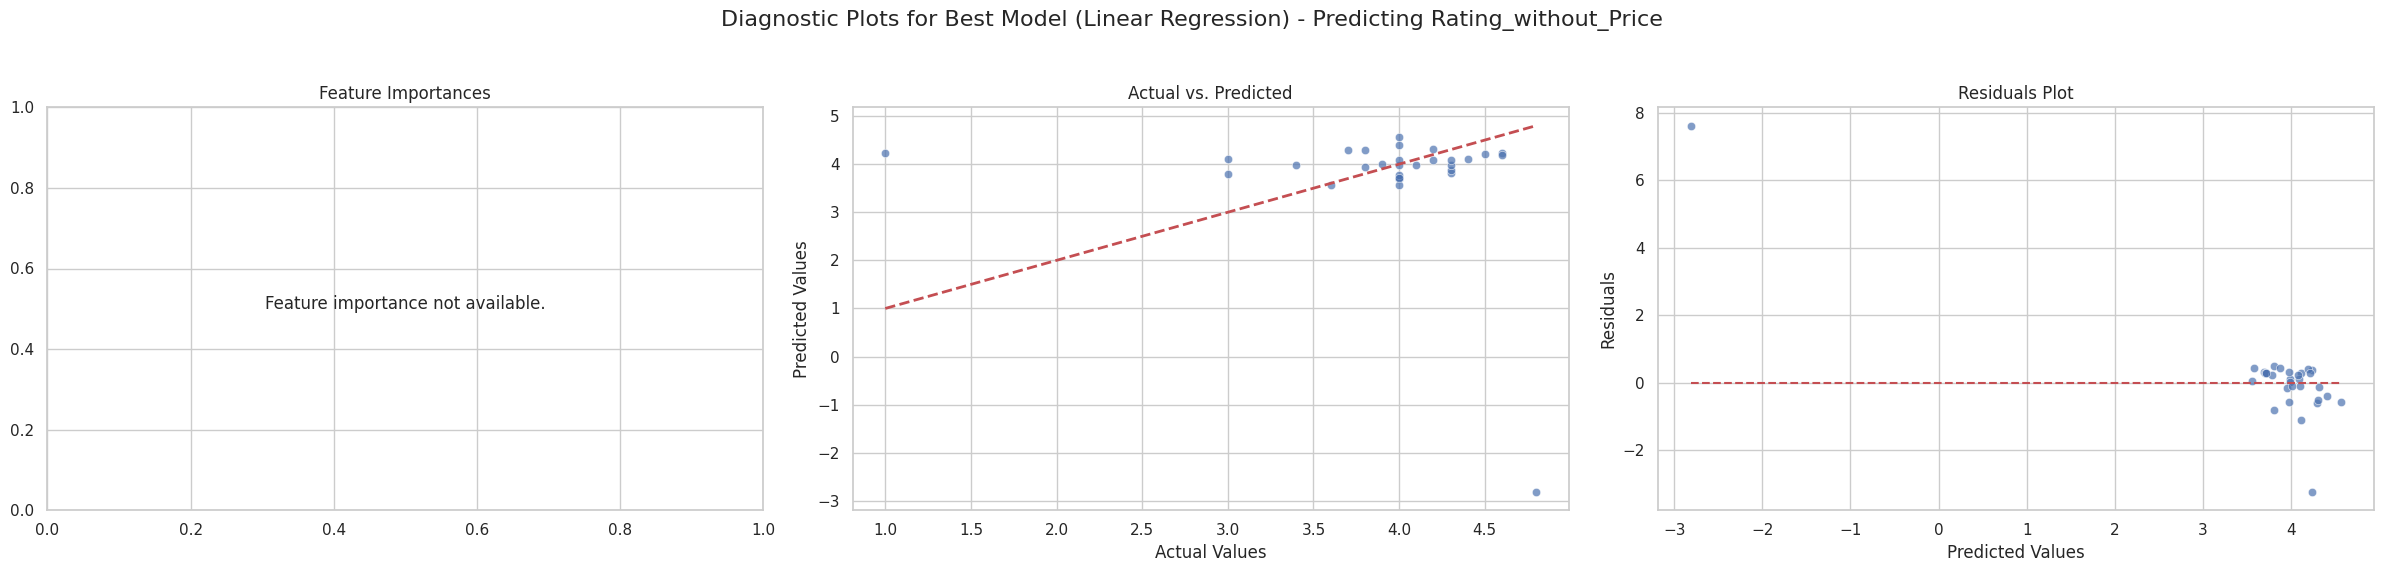

In [22]:
# --- Main Loop to Process All Categories ---
if 'all_data_files' in locals() and all_data_files:
    all_results = []
    for file_path in all_data_files:
        category_summary = run_full_analysis_for_category(file_path)
        all_results.append(category_summary)

In [23]:
# --- Final Summary Report Table ---
if 'all_results' in locals() and all_results:
    summary_df = pd.DataFrame(all_results)
    print("\n\n" + "="*80)
    print("---           Final Comprehensive Report: Best Model & R2 Score Per Task           ---")
    print("="*80)
    display(summary_df)



---           Final Comprehensive Report: Best Model & R2 Score Per Task           ---


Category  ... R2 (Rating_without_Price)
0           Juicer  ...                  0.401960
1        Gas_stove  ...                  0.683000
2     Meat_grinder  ...                  0.406697
3      Rice_cooker  ...                  3.706243
4            fryer  ...                  0.448856
5       Dishwasher  ...                  0.650665
6  Washing_machine  ...                  0.572248
7          Stirrer  ...                  0.589553
8     Refrigerator  ...                  0.670359

[9 rows x 7 columns]

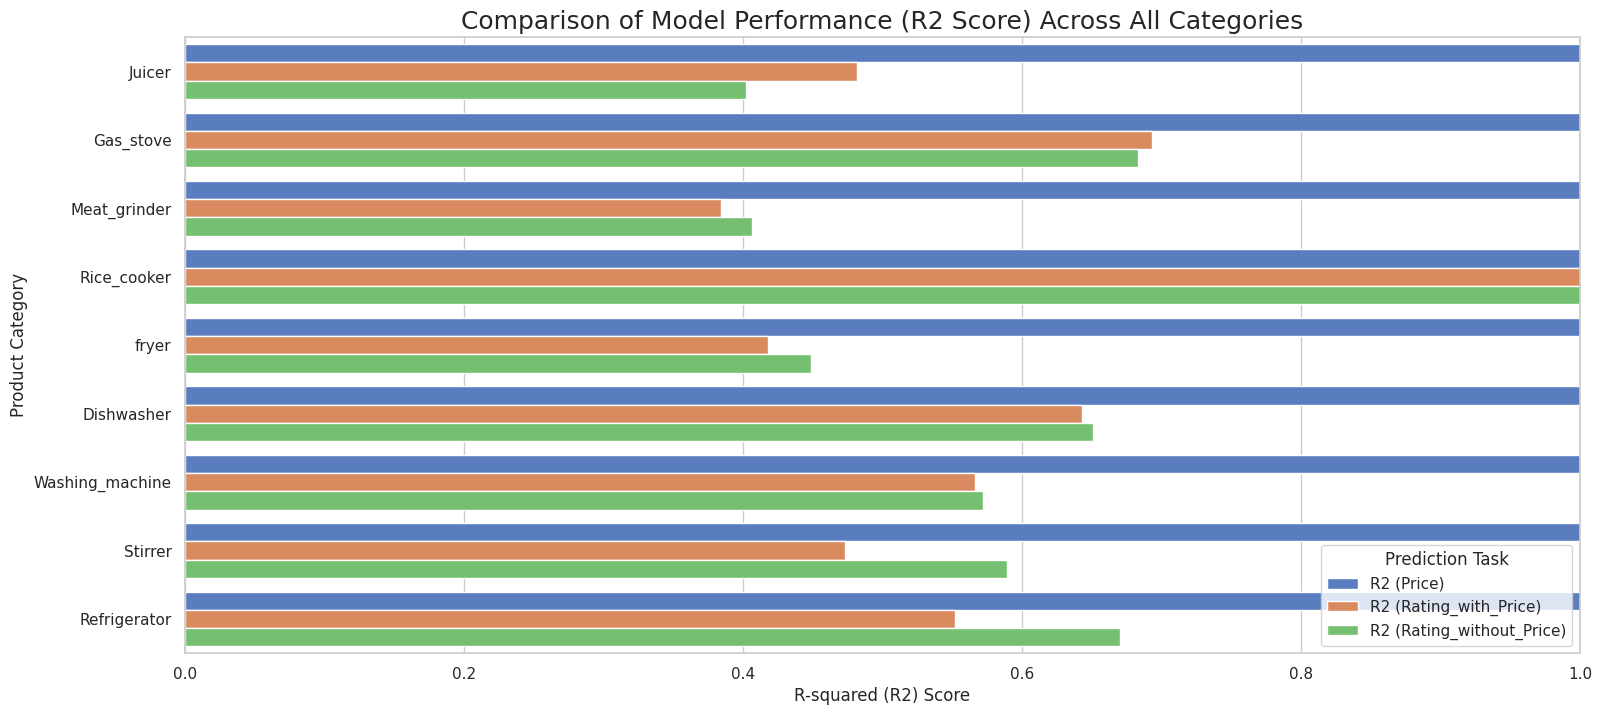

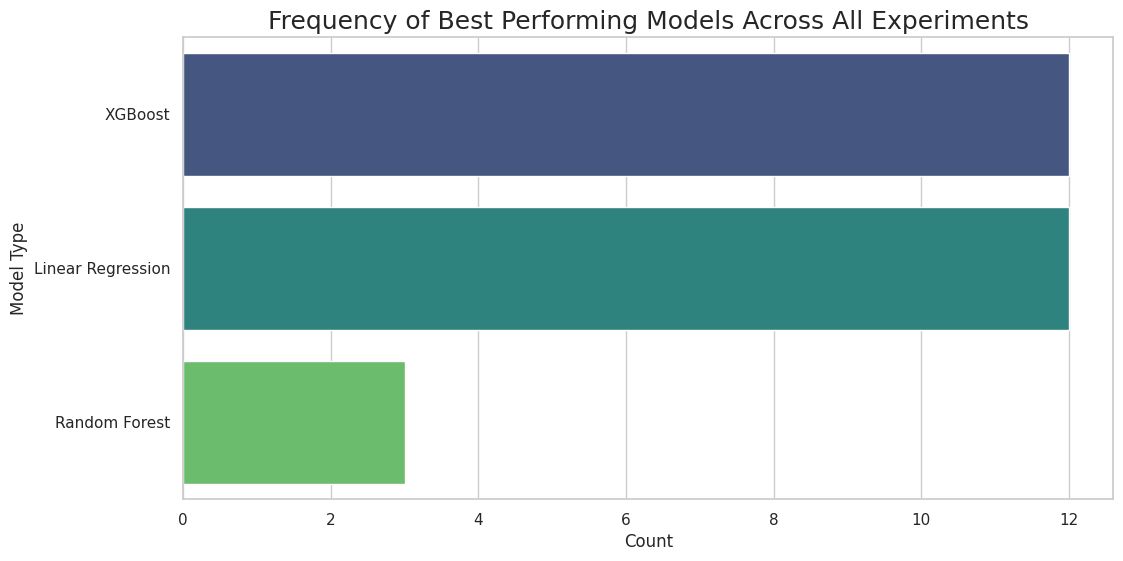

In [24]:
# --- Final Visual Summary Across All Categories ---

if 'summary_df' in locals():
    # --- Plot 1: Comparing R2 Scores Across Categories ---
    plot_df = summary_df.melt(id_vars='Category', 
                              value_vars=['R2 (Price)', 'R2 (Rating_with_Price)', 'R2 (Rating_without_Price)'],
                              var_name='Experiment', value_name='R2 Score')
    
    plt.figure(figsize=(18, 8))
    sns.barplot(data=plot_df, x='R2 Score', y='Category', hue='Experiment', palette='muted')
    plt.title('Comparison of Model Performance (R2 Score) Across All Categories', fontsize=18)
    plt.xlabel('R-squared (R2) Score')
    plt.ylabel('Product Category')
    plt.legend(title='Prediction Task')
    plt.xlim(0, 1)
    plt.show()

    # --- Plot 2: Tally of Best Performing Models ---
    model_cols = ['Best Model (Price)', 'Best Model (Rating_with_Price)', 'Best Model (Rating_without_Price)']
    best_models_tally = summary_df[model_cols].melt(var_name='Experiment', value_name='Best Model')
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=best_models_tally, y='Best Model', palette='viridis', order=best_models_tally['Best Model'].value_counts().index)
    plt.title('Frequency of Best Performing Models Across All Experiments', fontsize=18)
    plt.xlabel('Count')
    plt.ylabel('Model Type')
    plt.show()